### Team Classy Pie
---
# ■ Shelter Animal Outcomes, 보호소 동물들의 운명 예측하기

## Contents
> ### 1. Introduction -  프로젝트 소개
> ### 2. Datasets - 데이터 소개
> ### 3. Evaluation - 평가기준
> ### 4. EDA - 탐색적 자료 분석
> ### 5. Feature Engineering - 데이터 전처리
> ### 6. Modeling - Cross Validation - 모델링 및 검증 
> ### 7. To improve performance - 성능향상을 위한 추가사항
> ### 8. Submit Kaggle and get Score - 캐글 제출 및 결과확인
> ### 9. Conclusion - 결론


---

# 1. Introduction

    
> ### 1-1. 미국의 애완동물 현황
> - 미국 가정의 약 44%가 애완 동물을 기른다.
> - 매년 미국에서 760만 마리가 아래의 이유로 보호소에 오게 된다.    
    - 주인이 원치 않음
    - 길을 잃음
    - 학대를 당함
>
>
> - 보호소에 오는 동물들이 주인을 찾아가기도 하지만 **매년 270만 마리, 약 35%는 안락사**를 당한다.
    

> ### 1-2. 프로젝트 목표
> - 미국 텍사스의 **Austin Animal Center**는 모든 동물들에게 집을 찾아주는 것을 목표
> - 동물들의 특성 데이터를 제공해서 각 동물들의 결과를 예측
> - 입양이 덜 되는 동물들에게 에너지를 쏟아 입양률을 높이기 위한 목적

---
# 2. Datasets

- 총 3개의 파일
    
> ### 2-1. Train & Test
> - 2013.10 ~ 2016.03 기간동안 보호소에 온 강아지, 고양이의 정보
>
> - train.csv : the training set
> - test.csv : the test set
    

In [1]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [177]:
print("◆ Note : 트레인 파일은 아래와 같다.")
train.tail(3)

◆ Note : 트레인 파일은 아래와 같다.


,AnimalID,Name,DateTime,OutcomeType,OutcomeSubtype,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color
26726,A698128,Zeus,2015-03-09 13:33:00,Adoption,NaN,Dog,Neutered Male,4 years,Old English Bulldog Mix,White/Tan
26727,A677478,NaN,2014-04-27 12:22:00,Transfer,Partner,Cat,Intact Male,4 weeks,Domestic Shorthair Mix,Black
26728,A706629,NaN,2015-07-02 09:00:00,Transfer,SCRP,Cat,Intact Male,1 year,Domestic Shorthair Mix,Brown Tabby/White


In [178]:
print("◆ Note : 테스트 파일은 아래와 같다. 트래인 데이터와는 달리 Outcome관련 컬럼이 없다는걸 알 수 있다.")
test.tail(3)

◆ Note : 테스트 파일은 아래와 같다. 트래인 데이터와는 달리 Outcome관련 컬럼이 없다는걸 알 수 있다.


,ID,Name,DateTime,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color
11453,11454,NaN,2014-09-29 09:00:00,Cat,Intact Female,1 year,Domestic Shorthair Mix,Calico
11454,11455,Rambo,2015-09-05 17:16:00,Dog,Neutered Male,6 years,German Shepherd Mix,Black/Tan
11455,11456,Gusto,2014-07-12 18:40:00,Dog,Intact Male,4 years,Labrador Retriever,Cream


In [179]:
print(train.shape)

(26729, 10)


- Train data의 컬럼
    - OutcomeType (예측해야할 target 값)
    - OutcomeSubtype (OutcomeType과 연계된 부가정보)
    - +Test data의 컬럼들
- Test data의 컬럼
    - AnimalID(중복되지않는 고유 ID)
    - Name(이름이 없는 경우가 많음)
    - DateTime(Outcome이 발생한 날짜기록)
    - AnimalType(강아지, 고양이)
    - SexuponOutcome(성별 및 중성화여부, 5가지)
    - AgeuponOutcome(동물의 나이)
    - Breed(종)
    - Color(색상)

> ### 2-2. Submission
> - sample_submission.csv : a sample submission file in the correct format
    - 모든 동물들이 떠날때 클래스별 예측 확률

--- 
# 3. Evalutaion

    Submissions are evaluated using the multi-class logarithmic loss.
    
    where N is the number of animals in the test set, M is the number of outcomes
    log is the natural logarithm
    yij is 1 if observation i is in outcome j and 0 otherwise
    pij is the predicted probability that observation i belongs to outcome j.
    


$ \Large -\frac{1}{N} \sum \sum y_{ij}log(p_{ij}) $

---
# 4. EDA & Feature Engineering

In [2]:
import numpy as np
import scipy as sp
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.stats.api as sms
import sklearn as sk

%matplotlib inline
%config InlineBackend.figure_formats = {'png','retina'}

import matplotlib as mpl
import matplotlib.pylab as plt
from mpl_toolkits.mplot3d import Axes3D

import seaborn as sns
sns.set()
sns.set_style("whitegrid")
sns.set_color_codes()

pd.set_option('display.max_rows', 300)
pd.set_option('display.max_columns', 200)
pd.set_option('display.width', 1000)

## 4-1. raw data Analysis & Explore

In [181]:
print('-- 데이터 간략정보 --')
train.describe().T

-- 데이터 간략정보 --


,count,unique,top,freq
AnimalID,26729,26729,A672155,1
Name,19038,6374,Max,136
DateTime,26729,22918,2015-08-11 00:00:00,19
OutcomeType,26729,5,Adoption,10769
OutcomeSubtype,13117,16,Partner,7816
AnimalType,26729,2,Dog,15595
SexuponOutcome,26728,5,Neutered Male,9779
AgeuponOutcome,26711,44,1 year,3969
Breed,26729,1380,Domestic Shorthair Mix,8810
Color,26729,366,Black/White,2824


In [182]:
print("-- 컬럼별 null의 갯수 --")
pd.DataFrame(train.isnull().sum())

-- 컬럼별 null의 갯수 --


,0
AnimalID,0
Name,7691
DateTime,0
OutcomeType,0
OutcomeSubtype,13612
AnimalType,0
SexuponOutcome,1
AgeuponOutcome,18
Breed,0
Color,0


In [183]:
print('-- 중복자료 및 unique --')
train.describe().T

-- 중복자료 및 unique --


,count,unique,top,freq
AnimalID,26729,26729,A672155,1
Name,19038,6374,Max,136
DateTime,26729,22918,2015-08-11 00:00:00,19
OutcomeType,26729,5,Adoption,10769
OutcomeSubtype,13117,16,Partner,7816
AnimalType,26729,2,Dog,15595
SexuponOutcome,26728,5,Neutered Male,9779
AgeuponOutcome,26711,44,1 year,3969
Breed,26729,1380,Domestic Shorthair Mix,8810
Color,26729,366,Black/White,2824


-- OutcomeType의 내용 --


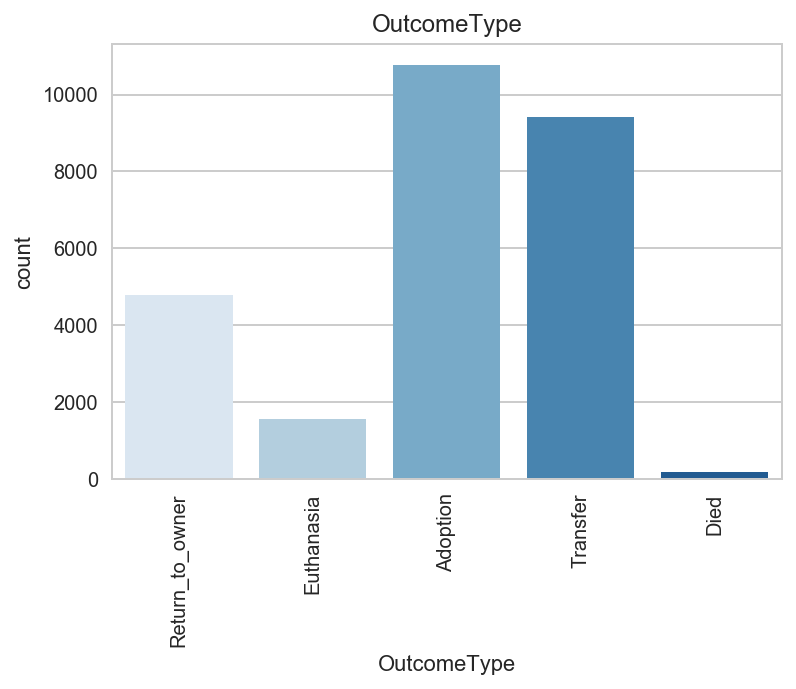

Adoption           10769
Transfer            9422
Return_to_owner     4786
Euthanasia          1555
Died                 197
Name: OutcomeType, dtype: int64

In [184]:
print("-- OutcomeType의 내용 --")
sns.countplot(x=train["OutcomeType"], data=train , palette="Blues")
plt.title('OutcomeType')
plt.xticks(rotation='vertical')
plt.show()
train["OutcomeType"].value_counts()

In [185]:
print("-- OutcomeSubtype의 내용 --")
train.groupby("OutcomeSubtype").size().reset_index(name='count').sort_values('count', ascending=False)

-- OutcomeSubtype의 내용 --


,OutcomeSubtype,count
12,Partner,7816
6,Foster,1800
14,SCRP,1599
15,Suffering,1002
0,Aggressive,320
11,Offsite,165
8,In Kennel,114
3,Behavior,86
13,Rabies Risk,74
10,Medical,66


In [186]:
print("-- AnimalType의 내용 --")
train.groupby("AnimalType").size().reset_index(name='count').sort_values('count',ascending=False)

-- AnimalType의 내용 --


,AnimalType,count
1,Dog,15595
0,Cat,11134


In [187]:
print("-- SexuponOutcome의 내용 --")
train.groupby("SexuponOutcome").size().reset_index(name='count').sort_values('count', ascending=False)

-- SexuponOutcome의 내용 --


,SexuponOutcome,count
2,Neutered Male,9779
3,Spayed Female,8820
1,Intact Male,3525
0,Intact Female,3511
4,Unknown,1093


In [188]:
print("-- AgeuponOutcome의 내용 --")
print("     - ※10개만 표시하고 중략")
train.groupby("AgeuponOutcome").size().reset_index(name='count').sort_values('count', ascending=False).head(10)

-- AgeuponOutcome의 내용 --
     - ※10개만 표시하고 중략


,AgeuponOutcome,count
5,1 year,3969
21,2 years,3742
19,2 months,3397
26,3 years,1823
2,1 month,1281
24,3 months,1277
30,4 years,1071
34,5 years,992
28,4 months,888
37,6 years,670


In [189]:
print("-- Breed의 내용 --")
print("     - 15개 항목만 표시하고 중략")
train.groupby("Breed").size().reset_index(name='count').sort_values('count', ascending=False).head(15)

-- Breed의 내용 --
     - 15개 항목만 표시하고 중략


,Breed,count
640,Domestic Shorthair Mix,8810
1066,Pit Bull Mix,1906
450,Chihuahua Shorthair Mix,1766
847,Labrador Retriever Mix,1363
637,Domestic Medium Hair Mix,839
696,German Shepherd Mix,575
632,Domestic Longhair Mix,520
1251,Siamese Mix,389
74,Australian Cattle Dog Mix,367
559,Dachshund Mix,318


In [190]:
print("-- Color의 내용 --")
print("    - 15개 항목만 표시하고 중략")
train.groupby("Color").size().reset_index(name='count').sort_values('count', ascending=False).head(15)

-- Color의 내용 --
    - 15개 항목만 표시하고 중략


,Color,count
38,Black/White,2824
5,Black,2292
104,Brown Tabby,1635
111,Brown Tabby/White,940
318,White,931
130,Brown/White,884
216,Orange Tabby,841
289,Tan/White,773
307,Tricolor,752
86,Blue/White,702


### NaN값 처리

In [368]:
# 나이정보가 없는 경우 10여 종류
train[train["AgeuponOutcome"].isnull() == True]

,AnimalID,Name,DateTime,OutcomeType,OutcomeSubtype,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color
2480,A720674,NaN,2016-02-16 10:17:00,Transfer,SCRP,Cat,Intact Male,NaN,Domestic Shorthair Mix,Blue Tabby/White
2912,A720973,NaN,2016-02-18 19:07:00,Transfer,SCRP,Cat,Unknown,NaN,Domestic Shorthair Mix,Gray Tabby
3766,A720820,NaN,2016-02-16 18:55:00,Transfer,SCRP,Cat,Intact Female,NaN,Domestic Shorthair Mix,Brown Tabby
3875,A721076,NaN,2016-02-20 16:37:00,Euthanasia,Suffering,Dog,Intact Male,NaN,Toy Poodle Mix,White
4498,A720422,NaN,2016-02-09 19:43:00,Transfer,SCRP,Cat,Intact Female,NaN,Domestic Shorthair Mix,Brown Tabby
5137,A720697,NaN,2016-02-16 10:17:00,Transfer,SCRP,Cat,Spayed Female,NaN,Domestic Shorthair Mix,Black
5691,A720640,NaN,2016-02-16 10:17:00,Transfer,SCRP,Cat,Unknown,NaN,Domestic Shorthair Mix,Black Tabby/White
7005,A720636,NaN,2016-02-16 10:17:00,Transfer,SCRP,Cat,Unknown,NaN,Domestic Shorthair Mix,Black
8420,A720701,NaN,2016-02-16 10:16:00,Transfer,SCRP,Cat,Intact Male,NaN,Domestic Shorthair Mix,Blue Tabby/White
17464,A720782,NaN,2016-02-16 18:55:00,Transfer,SCRP,Cat,Intact Female,NaN,Domestic Shorthair Mix,Torbie


In [3]:
# 나이정보가 없는 경우는 -1로 처리한뒤 차후에 Mode값에 산입
train["OutcomeSubtype"] = train["OutcomeSubtype"].fillna("NoStatus")
train["SexuponOutcome"] = train["SexuponOutcome"].fillna("Unknown")
train["AgeuponOutcome"] = train["AgeuponOutcome"].fillna("-1 nodata")
test["SexuponOutcome"] = test["SexuponOutcome"].fillna("Unknown")
test["AgeuponOutcome"] = test["AgeuponOutcome"].fillna("-1 nodata")


### 견종, 묘종 특징 컬럼 생성

In [306]:
Breed_dev = pd.DataFrame(columns=["Breed_extra","Breed_Life","Breed_Size",
                                  "Breed_Acti","Breed_Smrt","Breed_Frdy","Breed_Agsv"])
Breed_dev["Breed_extra"] = ['Abyssinian','Angora','Affenpinscher', 'AfghanHound', 'AiredaleTerrier',
       'Akita', 'AlaskanHusky', 'AlaskanMalamute',
       'AmericanBulldog', 'AmericanEskimo', 'AmericanFoxhound',
       'AmericanPitBullTerrier', 'AmericanStaffordshireTerrier',
       'AnatolShepherd', 'AustralianCattleDog',
       'AustralianKelpie', 'AustralianShepherd', 'AustralianTerrier',
       'Balinese', 'Basenji', 'BassetHound', 'Beagle', 'BeardedCollie',
       'Beauceron', 'BedlingtonTerr', 'BelgianMalinois', 'BelgianSheepdog',
       'BelgianTervuren', 'Bengal', 'BerneseMountainDog', 'BichonFrise',
       'BlackMouthCur', 'Bloodhound', 'BlueLacy', 'BluetickHound',
       'Boerboel', 'Bombay', 'BorderCollie', 'BorderTerrier', 'Borzoi',
       'BostonTerrier', 'Boxer', 'BoykinSpan', 'Brittany',         
       'BrussGriffon', 'BullTerrier', 'BullTerrierMiniature', 'Bulldog',
       'Bullmastiff', 'Burmese', 'CairnTerrier', 'CanaanDog', 'CaneCorso',
       'CardiganWelshCorgi', 'CarolinaDog', 'Catahoula', 'CavalierSpan',     
       'ChesaBayRetr', 'Chihuahua', 'ChineseCrested', 'ChineseSharpei',    
       'ChowChow', 'CockerSpaniel', 'CollieRough', 'CollieSmooth',
       'CornishRex', 'Cymric', 'Dachshund', 'DachshundWirehair',
       'Dalmatian', 'DevonRex', 'DobermanPinsch', 'DogoArgentino', 'DogueDeBordeaux',
       'DutchShepherd', 'EnglishBulldog', 'EnglishCockerSpaniel',
       'EnglishCoonhound', 'EnglishFoxhound', 'EnglishPointer',
       'EnglishSetter', 'EnglishShepherd', 'EnglishSpringerSpaniel',
       'Entlebucher', 'Exotic', 'Feist', 'FieldSpaniel', 'FinnishSpitz',
       'FlatCoatRetriever', 'FrenchBulldog', 'GermanPinscher',
       'GermanPointer', 'GermanShepherd', 'GermanWirehairedPointer',
       'GlenOfImaal', 'GoldenRetriever', 'GreatDane', 'GreatPyrenees',
       'GreaterSwissMountainDog', 'Greyhound', 'Harrier', 'HavanaBrown',
       'Havanese', 'Himalayan', 'Hovawart', 'IbizanHound', 'IrishSetter',
       'IrishTerrier', 'IrishWolfhound', 'ItalianGreyhound',
       'JackRussellTerrier', 'JapaneseBobtail', 'JapaneseChin', 'Javanese',
       'Jindo', 'Keeshond', 'Kuvasz', 'LabradorRetriever', 'Landseer',
       'Leonberger', 'LhasaApso', 'Lowchen', 'MaineCoon', 'Maltese',
       'ManchesterTerrier', 'Manx', 'Mastiff', 'MexicanHairless',
       'MiniaturePinscher', 'MiniaturePoodle', 'MiniatureSchnauzer',
       'Munchkin', 'NeapolitanMastiff', 'Newfoundland', 'NorfolkTerrier',
       'NorwegianElkhound', 'NorwegianForestCat', 'NorwichTerrier',
       'NovaScotiaDuckTollingRetriever', 'Ocicat', 'OldEnglishBulldog',
       'OldEnglishSheepdog', 'Otterhound', 'Papillon',
       'ParsonRussellTerrier', 'PatterdaleTerr',
       'Pbgv', 'Pekingese', 'PembrokeWelshCorgi', 'Persian',
       'PharaohHound', 'PicardySheepdog', 'PitBull', 'Pixiebob',
       'PlottHound', 'PodengoPequeno', 'Pointer', 'Pomeranian',
       'PortWaterDog', 'PresaCanario', 'Pug', 'QueenslandHeeler',
       'Ragdoll', 'RatTerrier', 'RedboneHound', 'Rex', 'RhodRidgeback',
       'Rottweiler', 'RussianBlue', 'Saluki', 'Samoyed', 'Schipperke',
       'SchnauzerGiant', 'ScottishTerrier', 'SealyhamTerr',
       'ShetlandSheepdog', 'ShibaInu', 'ShihTzu', 'Siamese',
       'SiberianHusky', 'SilkyTerrier', 'SkyeTerrier', 'SmoothFoxTerrier',
       'Snowshoe', 'SoftCoatedWheatenTerrier', 'SpanishMastiff',
       'SpanishWaterDog', 'Sphynx', 'SpinoneItaliano',
       'St.BernardRoughCoat', 'St.BernardSmoothCoat', 'Staffordshire',
       'StandardPoodle', 'StandardSchnauzer', 'SwedishVallhund',
       'SwissHound', 'TanHound', 'TibetanSpaniel', 'TibetanTerrier',
       'Tonkinese', 'ToyFoxTerrier', 'ToyPoodle', 'TreeingCur',
       'TreeingTennesseBrindle', 'TreeingWalkerCoonhound', 'TurkishVan',
       'Unknown', 'Vizsla', 'Weimaraner', 'WelshSpringerSpaniel',
       'WelshTerrier', 'WestHighland', 'Whippet', 'WireHairFoxTerrier',
       'WirehairedPointingGriffon', 'Yorkshire', 'YorkshireTerrier',
       '', 'American', 'Black', 'British',
       'Cirneco', 'CotonDeTulear', 'DachshundStan', 'DandieDinmont', 'EngToySpaniel','GordonSetter',
       'ScottishFold', 'AmericanWirehair', 'OrientalSh', 'Chartreux', 'TurkishAngora']

Breed_dev["Breed_Life"] = [12,12,13,15,13,12,13,12,13,14,12,12,14,12,14,12,14,13,20,14,13,13,13,11,14,15,13,13,12,
                          9,15,15,11,16,12,10,17,14,14,12,12,11,13,13,14,13,12,9,8,14,14,14,11,14,14,12,
                          14,12,15,16,10,10,12,13,13,12,12,14,14,12,13,
                          11, 11, 7, 13, 9, 13, 12, 12, 13, 12, 15, 13, 13, 13, 12, 13, 14, 9, 11, 13, 11, 9, 15, 13, 11, 9, 11, 10, 12, 14, 13, 15, 10, 12, 13, 14, 14, 7, 15, 15, 11, 11, 10, 14, 14, 11, 11, 9, 7, 14, 14, 12, 14, 16, 11, 8, 14, 14, 14, 14, 14, 8, 10, 14, 14, 11, 14, 13, 14, 12, 11, 12, 15, 14, 14,
                          13,14,13,14,13,13,11,13,13,14,13,14,14,10,14,14,15,17,12,14,11,9,17,13,13,14,14,14,13,13,14,14,11,14,14,14,14,14,14,12,14,13,9,9,12,14,15,14,13,11,14,14,14,13,15,14,14,11,13,15,0,14,11,14,14,14,14,13,11,15,15,
                          11,11,11,11,13,17, 14, 14, 11, 13,15,17,14,17,15] #수명
Breed_dev["Breed_Size"] = [1,1,1,3,3,3,2,3,3,2,3,1,3,3,2,3,2,1,0,2,2,2,2,3,1,3,3,3,1,3,1,2,3,2,3,3,0,2,1,3,1,3,2,2,1,3,2,2,3,1,1,2,2,2,2,3,1,3,0,1,2,3,2,3,3,0,1,1,1,3,0,
                          3, 3, 3, 3, 2, 2, 2, 3, 3, 3, 2, 2, 2, 1, 2, 2, 2, 3, 2, 2, 3, 3, 3, 2, 3, 3, 3, 3, 3, 2, 1, 1, 1, 3, 3, 3, 2, 3, 1, 1, 1, 1, 1, 2, 2, 3, 3, 3, 3, 1, 1, 1, 0, 1, 1, 3, 2, 1, 1, 1, 0, 3, 3, 1, 2, 1, 1, 2, 1, 3, 3, 3, 0, 1, 1,
                          2,1,2,1,3,3,2,1,3,1,3,0,2,3,1,2,1,1,3,1,3,3,0,2,2,1,3,1,1,1,1,1,1,2,1,2,1,1,2,3,3,1,3,3,3,3,3,2,2,2,3,1,2,1,0,0,2,2,3,1,4,3,3,2,1,1,2,1,3,0,0,
                          4,4,4,4,1,1, 1, 1, 1, 3, 1,1,0,2,0] #크기(0,1,2,3단계-[4kg미만, 10kg미만, 25kg미만, 25kg이상, 알수없음])
Breed_dev["Breed_Acti"] = [0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1,1,1,1,1,1,1,1,1,0,1,1,1,1,1,1,1,0,1,1,0,1,1,1,1,1,1,1,1,1,0,1,1,1,1,2,1,1,1,1,1,0,0,1,1,1,0,0,1,1,1,0,
                          1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1,
                          1,0,1,0,1,1,1,1,0,1,1,1,0,0,0,0,0,0,1,1,0,1,0,0,1,1,0,1,0,1,1,0,1,1,1,0,1,1,1,0,1,1,0,0,0,0,1,1,1,0,1,1,1,1,1,1,0,0,0,1,0,0,0,1,1,1,0,1,0,1,1,
                          2,2,2,2,0,1,1,0,1,0, 1,1,1,0,0] #활동성
Breed_dev["Breed_Smrt"] = [1,1,0,0,1,1,1,1,1,1,0,1,1,1,1,1,1,1,0,1,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1,0,1,0,0,1,0,0,0,1,1,0,1,1,1,0,1,0,1,0,0,1,1,1,1,1,1,1,1,1,1,1,
                          1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1,
                          0,1,1,0,1,1,0,0,1,1,0,1,1,1,1,0,0,1,0,0,1,1,1,1,0,1,1,1,0,1,1,1,1,1,0,1,1,1,1,1,1,0,0,1,1,0,1,1,1,1,0,1,0,0,0,1,0,1,1,1,0,0,1,1,1,0,1,0,1,1,1,
                          2,2,2,2,0,1,1,1,1,0, 1,1,1,1,1] #영리함
Breed_dev["Breed_Frdy"] = [0,0,1,1,1,0,1,1,1,0,1,1,1,1,1,1,1,1,0,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1,1,1,0,1,1,1,1,1,1,1,1,1,1,1,1,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,1,1,1,0,
                          1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
                          1,1,0,0,1,0,1,1,1,1,1,1,1,0,1,1,1,1,1,1,1,1,1,0,1,0,1,0,1,1,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,1,0,1,1,0,1,1,1,0,1,1,1,1,0,1,0,1,1,0,1,1,1,0,0,
                          2,2,2,2,1,0,1,1,0,1, 1,1,1,1,1] #사교성, 충성심
Breed_dev["Breed_Agsv"] = [0,0,0,0,0,0,1,0,1,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,
                          0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
                          0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,
                          2,2,2,2,0,0,0,0,0,0, 0,0,0,0,0] #공격성 (pitbull류)



## 4-2. Feature Engineering & Analysis

### - 비정형 데이터 -->정리 --> 정형화 함수(Categorizing)

In [257]:
# 전처리함수(수정가능)---------------
import datetime as dt


def preprocessShelter(df_raw):
    df = df_raw.copy()
    # Name --> Isname------------------------------------------
    df['Name'].fillna('Unknown', inplace=True)

    # 이름이 있으면 Has_name, 이름이 없으면 Unknown------------
    name = []
    for i in df['Name']:
        if i == 'Unknown':
            name.append('Unknown_name')
        else:
            name.append('Has_name')
    df['Name'] = name
    
    
    # color정리 - black, white, brown, others로 나눔
#     color = []
#     for i in df['Color']:
#         if i[:5] == 'Black':
#             color.append('Black')
#         elif i[:5] == 'White':
#             color.append('White')
#         elif i[:5] == 'Brown':
#             color.append('Brown')
#         else:
#             color.append('C_Others')
#     df['Color_1st'] = color    
    
    #--------------------------------------------1차 추가되는 컬럼정리(나이, 성별)
    
    df["sex_intact"] = (df["SexuponOutcome"].str.slice(0,6) == "Intact").astype(int)
    df["sex_unknown"] = (df["SexuponOutcome"] == "Unknown").astype(int)
    df["sex_mf"] = (df["SexuponOutcome"].str.split(' ', n=2, expand=True)[1] == "Male").astype(int)
    df.sex_mf[df["sex_unknown"]==1] = 2
    df.sex_intact[df["sex_unknown"]==1] = 2
    
    # 나이데이터 재정리 (Agenbr=나이의숫자만, Age_tscale=(day,week,month,year), Age_yscale=동물의 연생, 
    df["Age_nbr"] = df["AgeuponOutcome"].str.slice(0,2).astype(int) # 0인값의경우 해당 동물의 나이정보가 없는것으로 추정한다
    df["Age_tscale"] = df["AgeuponOutcome"].str.split(" ", n=2, expand=True)[1] # 띄어쓰기 된 뒷문장 가져오기
    df["Age_tscale"] = df["Age_tscale"].replace("s","",regex=True) # 문자 s를 삭제
    df["Age_yscale"] = df["Age_tscale"].replace(["day","week","month"],"under_year")
    df["Age_ynbr"] = df["Age_nbr"].copy()
    df.Age_ynbr[df["Age_yscale"]=="under_year"] = 0
    
    df["Age_daily_scale"] = 0
    df.Age_daily_scale[df['Age_tscale']=="day"] = 1
    df.Age_daily_scale[df['Age_tscale']=="week"] = 7
    df.Age_daily_scale[df['Age_tscale']=="month"] = 30
    df.Age_daily_scale[df['Age_tscale']=="year"] = 365
    df["Age_daily_scale"] = df["Age_daily_scale"]*df["Age_nbr"]

    # 어린친구, 성체, 나이든친구
    df["Age_code"] = 0
    df.Age_code[(df['Age_ynbr']>=1)|(df['Age_ynbr']<=3)] = 1
    df.Age_code[(df['Age_ynbr']>=4)] = 2
    
    # Breed 정제 - 1차 - 김민우
    df["Breed_Do"] = 0
    df["Breed_Mx"] = 0
    df["Breed_Lh"] = 0
    df["Breed_Mh"] = 0
    df["Breed_Sh"] = 0
    df["Breed_dogM"] = 0
    df.Breed_Do[df['Breed'].str.contains("Domestic", regex=True)] = 1
    df.Breed_Mx[df['Breed'].str.contains("Mix", regex=True)] = 1
    df.Breed_Lh[df['Breed'].str.contains("Longhair", regex=True)] = 1
    df.Breed_Sh[df['Breed'].str.contains("Shorthair", regex=True)] = 1
    df.Breed_Mh[df['Breed'].str.contains("MediumHair", regex=True)] = 1
    df.Breed_dogM[df['Breed'].str.contains("/", regex=True)] = 1
    df["Breed_extra"] = df["Breed"].replace(["Domestic","Mix"," ","Shorthair","Longhair","MediumHair",""],"",regex=True) # 문자 s를 삭제

    df["Breed_Pitbull"] = df["Breed_extra"].str.contains("PitBull",regex=True)

    # Breed 정제 - 2차 -정혜란님 아이디어
#     df["Breed_Sheepdog"] = 0 #쉐퍼드견 포함
#     df["Breed_Terrier"] = 0
#     df["Breed_Hound"] = 0
    
#     df["Breed_Chihuahua"] = 0
#     df["Breed_Pitbull"] = 0
#     df["Breed_Retriver"] = 0
#     df["Breed_Bullbog"] = 0
#     df["Breed_Poodle"] = 0
    
#     df["Breed_English"] = 0
#     df["Breed_American"] = 0
#     df["Breed_Chinese"] = 0
#     df["Breed_German"] = 0
#     df["Breed_OtherNT"] = 0
    


    # 시간데이터 정제
    temp = pd.to_datetime(df['DateTime'])
    df["Time_year"] = temp.dt.strftime("%Y").astype(int)
    df["Time_month"] = temp.dt.strftime("%m").astype(int)
    df["Time_DOW"] = temp.dt.dayofweek.astype(int)
    df["Time_day"] = temp.dt.strftime("%d").astype(int)
    df["Time_hour"] = temp.dt.strftime("%H").astype(int)
    df["Time_weekend"] = (df['Time_DOW'] >= 5).astype(int)
    df["Time_operating"] = 0
    df.Time_operating[(df['Time_hour']>=5)|(df['Time_hour']<=10)] = 1
    df.Time_operating[(df['Time_hour']>=11)|(df['Time_hour']<=15)] = 2
    df.Time_operating[(df['Time_hour']>=16)|(df['Time_hour']<=18)] = 3
    df.Time_operating[df['Time_hour']==19] = 4
    
    df["Time_season"] = ((df["Time_month"]%12)//3).astype(int)
    
    
    # 미 텍사스주 공휴일
    
    df["Holidays"] = 0
    df.Holidays[(df['Time_month']==1)&(df['Time_day']==19)]=1
    df.Holidays[(df['Time_month']==3)&(df['Time_day']==2)]=1
    df.Holidays[(df['Time_month']==4)&(df['Time_day']==21)]=1
    df.Holidays[(df['Time_month']==5)&(df['Time_day']==10)]=1
    df.Holidays[(df['Time_month']==6)&(df['Time_day']==19)]=1
    df.Holidays[(df['Time_month']==6)&(df['Time_day']>=18)&(df['Time_day']<=22)]=2
    df.Holidays[(df['Time_month']==8)&(df['Time_day']==27)]=1
    df.Holidays[(df['Time_month']==11)&(df['Time_day']==11)]=1
    df.Holidays[(df['Time_month']==11)&(df['Time_day']>=25)&(df['Time_day']<=27)]=2
    df.Holidays[(df['Time_month']==12)&(df['Time_day']>=23)&(df['Time_day']<=27)]=2
    
    return df




def preprocessColorBreed(df,Breed_dev):
    
    #Breed 정제 2차 - 전현일 - 코드최적화 김민우
#     df_B = pd.DataFrame()
#     ls = [i for data in list(df["Breed_extra"]) for i in data.split("/") ]
#     breeds = np.unique(ls)
#     for i in breeds[1:]:
#         df_B[i] = df['Breed_extra'].str.contains(i, regex=True).astype(int)
        
    #Breed 정제 3차 - 김민우,전현일,정혜란
    ㅑㅑ
#     df_B["Breed_Acti"] = 2
    cnt = 0
    for i in list(Breed_dev["Breed_extra"]):
        print(cnt,end=" ")
        df_B.Breed_Life[df["Breed_extra"]==i] =  int(Breed_dev[Breed_dev["Breed_extra"]==i].Breed_Life)
        df_B.Breed_Size[df["Breed_extra"]==i] =  int(Breed_dev[Breed_dev["Breed_extra"]==i].Breed_Size) 
        df_B.Breed_Acti[df["Breed_extra"]==i] =  int(Breed_dev[Breed_dev["Breed_extra"]==i].Breed_Acti) 
        df_B.Breed_Smrt[df["Breed_extra"]==i] =  int(Breed_dev[Breed_dev["Breed_extra"]==i].Breed_Smrt) 
        df_B.Breed_Frdy[df["Breed_extra"]==i] =  int(Breed_dev[Breed_dev["Breed_extra"]==i].Breed_Frdy) 
        df_B.Breed_Agsv[df["Breed_extra"]==i] =  int(Breed_dev[Breed_dev["Breed_extra"]==i].Breed_Agsv) 
        cnt += 1

    # 믹스견의 경우 분배문제가 있음. ==> 둘중 하나라도 1이면 1로 본다. + 나이는 작은것을 채택한다.
    
    print("\nUnknown_name process...")
    for i,row in df.iterrows():
        if i%1000 == 0:
            print(i//1000,"..",end=" ")
        if "/" in row.Breed_extra: #.str.contains("/", regex=True):
            Lfe = 0
            Sze = 0
            Act = 0
            Smt = 0
            Fmy = 0
            Agr = 0
            count = 0
            for j in row.Breed_extra.split("/"):
                count += 1
                try:
                    Lfe += int(Breed_dev[Breed_dev["Breed_extra"]==j].Breed_Life)
                    Sze += int(Breed_dev[Breed_dev["Breed_extra"]==j].Breed_Size)
                    Act += int(Breed_dev[Breed_dev["Breed_extra"]==j].Breed_Acti)
                    Smt += int(Breed_dev[Breed_dev["Breed_extra"]==j].Breed_Smrt)
                    Fmy += int(Breed_dev[Breed_dev["Breed_extra"]==j].Breed_Frdy)
                    Agr += int(Breed_dev[Breed_dev["Breed_extra"]==j].Breed_Agsv)
                except :
                    print("no breed err:",i,end="")
                    count = 1
                    Lfe = 12
                    Sze = 4
                    Act = 0
                    Smt = 0
                    Fmy = 0
                    Agr = 0
                    break
                    
            df_B.set_value(i,"Breed_Life",int(Lfe // count))    
            df_B.set_value(i,"Breed_Size",int(Sze // count)) 
            df_B.set_value(i,"Breed_Acti",int(Act>0)) 
            df_B.set_value(i,"Breed_Smrt",int(Smt>0))
            df_B.set_value(i,"Breed_Frdy",int(Fmy>0))
            df_B.set_value(i,"Breed_Agsv",int(Agr>0))
            
    #예상 남은수명 계산
    try:
        df_B["Breed_RestLife"] = (df_B["Breed_Life"].astype(int)*365 - df["Age_daily_scale"])//365
    except:
        print("RestLife - err occured!")
        print("Breed_Life len : " ,len(df_B["Breed_Life"]))
        print("Agedaliy_scale len : " ,len(df["Age_daily_scale"]))
        print("dtype :",df_B.dtypes)
        return df_B, df_B
        print(df_B.Breed_Size.astype(int))
        print(df_B.Breed_Acti.astype(int))
        print(df_B.Breed_Smrt.astype(int))
        print(df_B.Breed_Frdy.astype(int))
        print(df_B.Breed_Agsv.astype(int))
        print(df_B.Breed_Life.astype(int))
        
        
    df_B = df_B.astype(int)
    
    print("\ncolor classificating...",end=" ")
    #Color 정제 2차 - 정혜란, 전현일
    df_C = pd.DataFrame()
    
    df_C["Color_mix"] = df["Color"].copy()
    df_C["Color_mix"] = 1
    df_C.Color_mix[df["Color"].str.contains("/|Sable|Seal Point|Lilac Point", regex=True)==True] = 2
    df_C.Color_mix[df["Color"].str.contains("Tricolor|Calico|Tortie|Torbie", regex=True)==True] = 3
    
    df_C["Color_extra"] = df["Color"].str.contains("Cream|Buff|Fawn|Apricot|Flame Point", regex=True).astype(int)
    df_C["Color_ful"] = df["Color"].str.contains("Blue|Red|Green", regex=True).astype(np.int8)
    df_C["Color_black"] = df["Color"].str.contains("Black", regex=True).astype(np.int8)
    df_C["Color_white"] = df["Color"].str.contains("White", regex=True).astype(np.int8)
    df_C["Color_gray"] = df["Color"].str.contains("Lynx|Gray|Silver", regex=True).astype(np.int8)
    df_C["Color_gold"] = df["Color"].str.contains("Orange|Yellow|Gold", regex=True).astype(np.int8)
    df_C["Color_brown"] = df["Color"].str.contains("Brown|Tan|Chocolate", regex=True).astype(np.int8)
    print("Complete!")
    
    return df_C, df_B #, breeds


#--------아래는 All카테고라이저, All원핫인코더 함수-------

from sklearn.preprocessing import LabelEncoder
def allCategorizer(df, columns=[]):

    print("Categorizing start... using ", columns)
    
    if len(columns) == 0:
        col_name = df.columns
        col_num = len(col_name)
    else :
        col_name = columns
        col_num = len(col_name)
    
    temp = df[col_name].copy()
    
    for i in range(col_num):
        le = LabelEncoder()
        y = temp[col_name[i]]
        le.fit(y)
        temp[col_name[i]] = le.transform(y)
        print(i,", ",end="")
    print("Complete!")
    return temp.astype(np.int8)        
        
def allOneHotEncoder(df, columns=[]):
    print("One_Hot_Encoding start... using ", columns)

    if len(columns) == 0:
        col_name = df.columns
        col_num = len(col_name)
    else :
        col_name = columns
        col_num = len(col_name)
        
    for i in range(col_num):
        temp = pd.get_dummies(df[col_name[i]])
        if i == 0 : 
            onehot_df = temp.copy()
            print(i,", ",end="")
        else : 
            onehot_df = pd.concat([onehot_df,temp], axis=1)
            print(i,", ",end="")
    print("Complete!")
    return onehot_df



# 전처리된 데이터프레임 설정 --> df_train -------------------

# df_train = preprocessShelter(train)
# df_colors, df_breeds = preprocessColorBreed(df_train,Breed_dev)

In [253]:
# print(df_train.columns,"\n")
# print(df_breeds.columns,"\n")
# print(df_colors.columns)
# df_train.describe().T
df_train.tail()

,AnimalID,Name,DateTime,OutcomeType,OutcomeSubtype,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color,sex_intact,sex_unknown,sex_mf,Age_nbr,Age_tscale,Age_yscale,Age_ynbr,Age_daily_scale,Age_code,Breed_Do,Breed_Mx,Breed_Lh,Breed_Mh,Breed_Sh,Breed_dogM,Breed_extra,Breed_Pitbull,Time_year,Time_month,Time_DOW,Time_day,Time_hour,Time_weekend,Time_operating,Time_season,Holidays
26724,A702446,Unknown_name,2015-05-14 11:56:00,Transfer,Partner,Cat,Intact Male,1 month,Domestic Shorthair Mix,Brown Tabby/White,1,0,1,1,month,under_year,0,30,1,1,1,0,0,1,0,,False,2015,5,3,14,11,0,3,1,0
26725,A718934,Unknown_name,2016-01-20 18:59:00,Transfer,SCRP,Cat,Spayed Female,3 months,Domestic Shorthair Mix,Brown Tabby,0,0,0,3,month,under_year,0,90,1,1,1,0,0,1,0,,False,2016,1,2,20,18,0,3,0,0
26726,A698128,Has_name,2015-03-09 13:33:00,Adoption,NoStatus,Dog,Neutered Male,4 years,Old English Bulldog Mix,White/Tan,0,0,1,4,year,year,4,1460,2,0,1,0,0,0,0,OldEnglishBulldog,False,2015,3,0,9,13,0,3,1,0
26727,A677478,Unknown_name,2014-04-27 12:22:00,Transfer,Partner,Cat,Intact Male,4 weeks,Domestic Shorthair Mix,Black,1,0,1,4,week,under_year,0,28,1,1,1,0,0,1,0,,False,2014,4,6,27,12,1,3,1,0
26728,A706629,Unknown_name,2015-07-02 09:00:00,Transfer,SCRP,Cat,Intact Male,1 year,Domestic Shorthair Mix,Brown Tabby/White,1,0,1,1,year,year,1,365,1,1,1,0,0,1,0,,False,2015,7,3,2,9,0,3,2,0


### - Name & OutcomeType

- `Name` column preprocessing
    - 동물의 이름
    - 동물이 이름을 가지고 있으면 Has_name, 이름을 가지지 않으면 Unknown


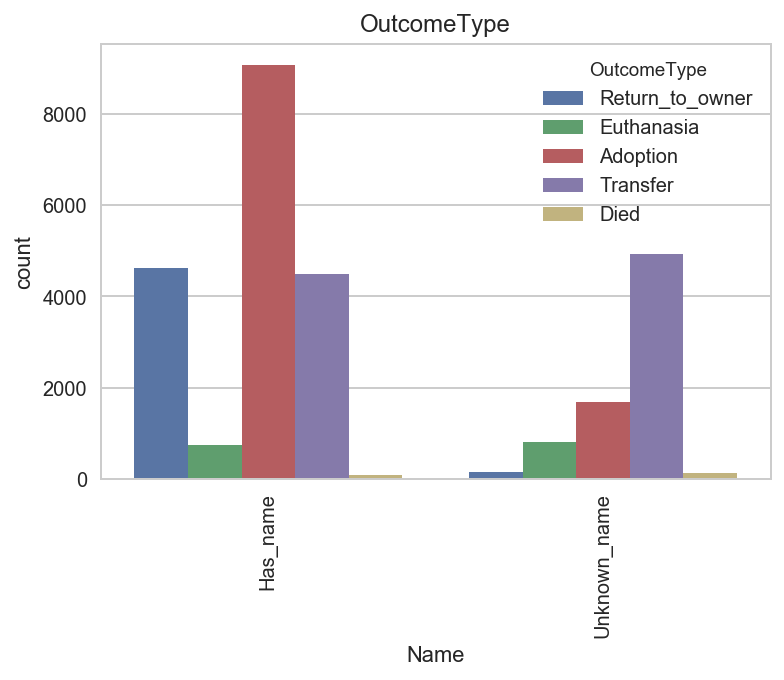

In [1056]:
# 이름이 있는 경우 어덥션 높고 이름 없는 경우 transfer 높다.
sns.countplot(x="Name", data=df_train , hue ='OutcomeType')
plt.title('OutcomeType')
plt.xticks(rotation='vertical')
plt.show() 

### - AnimalType & OutcomeType

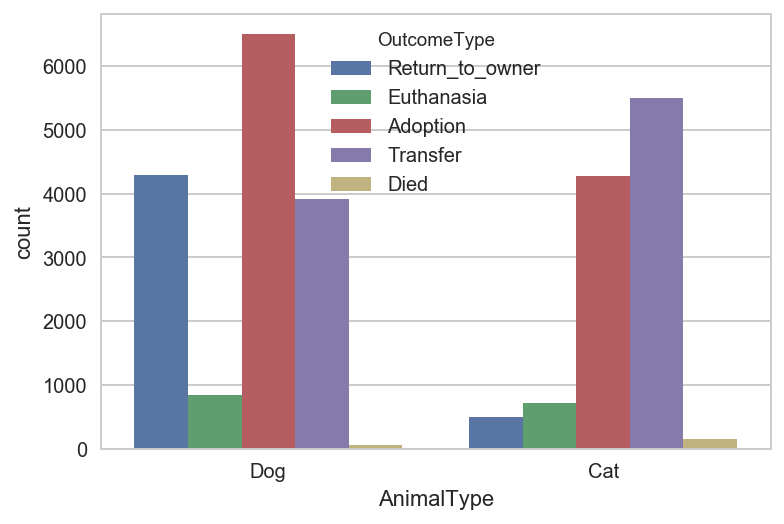

In [159]:
sns.countplot(x='AnimalType',data=df_train, hue='OutcomeType')
plt.show()

### - SexuponOutcome & OutcomeType

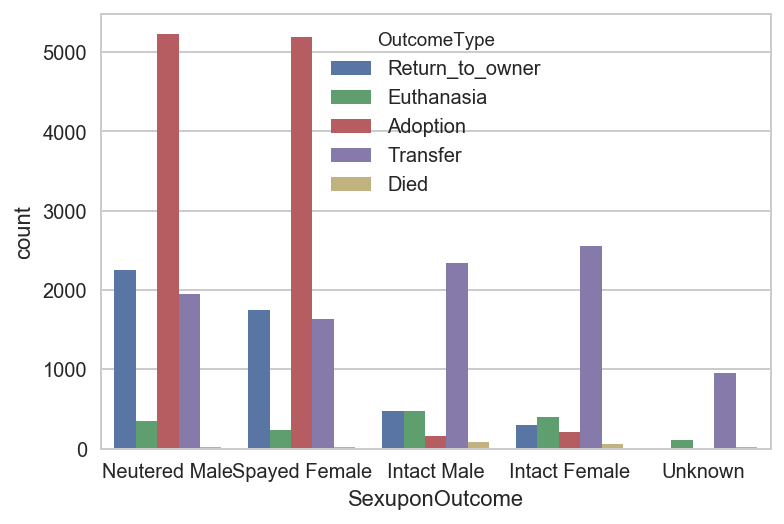

In [160]:
# 중성화 된 동물들의 어덥션이 높고 중성화 되지 않은 동물들이 transfer 된 경우가 많음
sns.countplot(x='SexuponOutcome',data=train, hue='OutcomeType')
plt.show()

### - AgeuponOutcome & OutcomeType

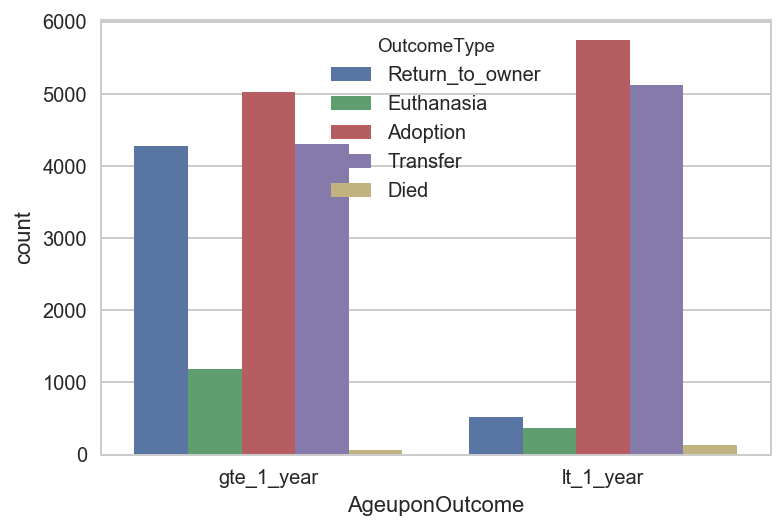

In [163]:
# 1살 이상의 동물들이 주인에게 돌아가는 경우가 많다.
sns.countplot(x='AgeuponOutcome',data=df_train, hue='OutcomeType')
plt.show()

동물의 나이별(년) 개체수 통계


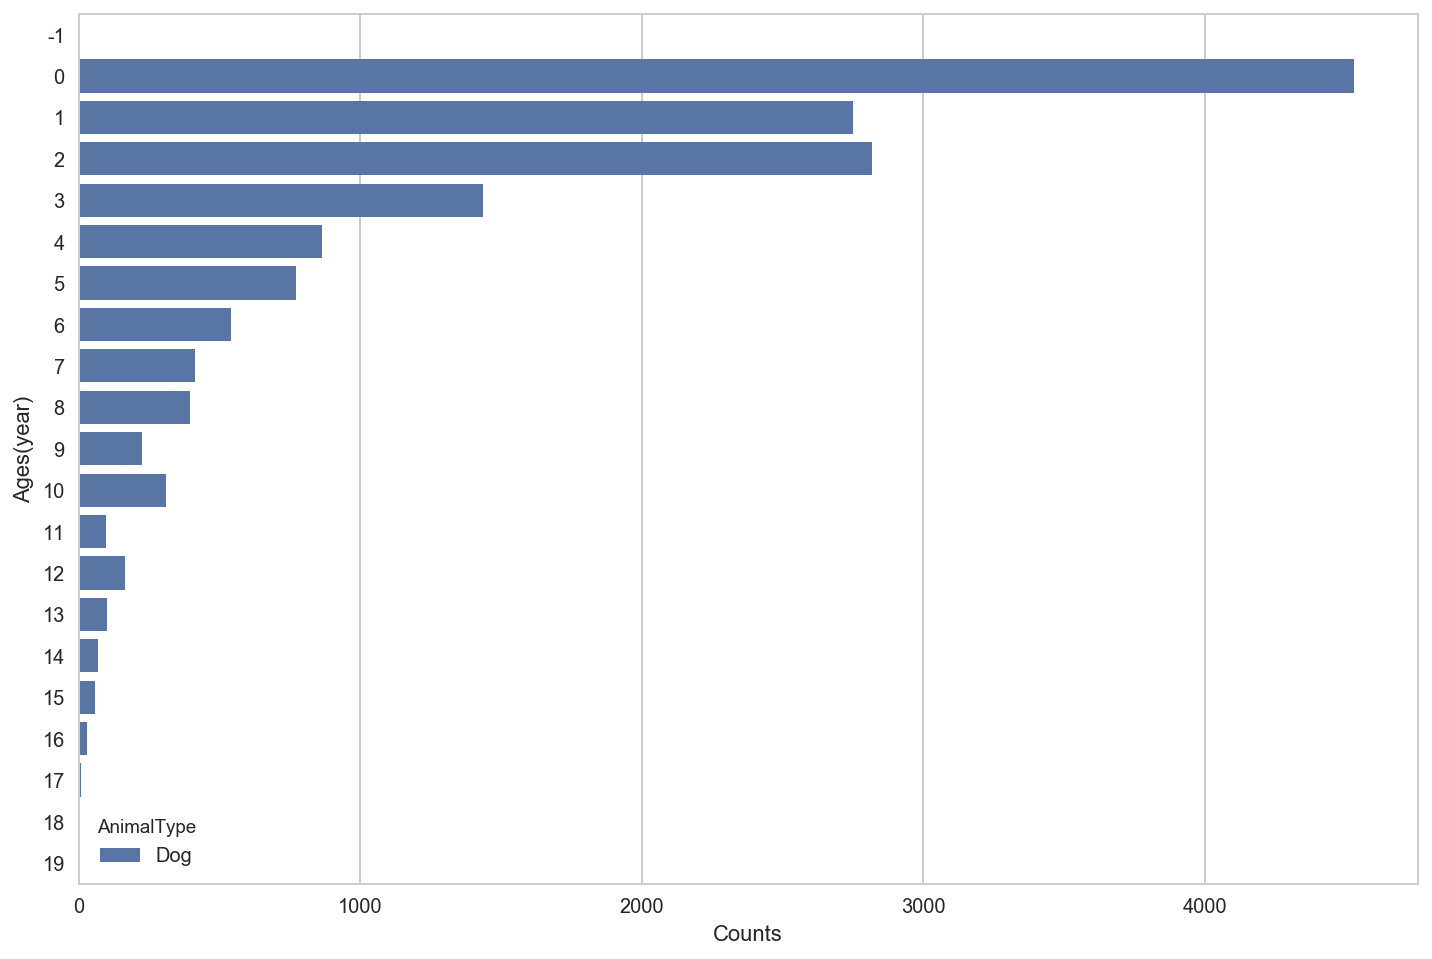

In [470]:
# 위 그래프 정제결과1 : 동
sorted_df = df_train.groupby(["Age_ynbr","AnimalType"]).size().reset_index(name="count")
sorted_df['Age_ynbr'] = pd.Categorical(sorted_df['Age_ynbr'])
fig = plt.figure(figsize=(12,8))
ax = sns.barplot(data = sorted_df, x="count", y="Age_ynbr", hue="AnimalType")
ax.set_xlabel('Counts')
ax.set_ylabel('Ages(year)')
print("동물의 나이별(년) 개체수 통계")

### - Color & OutcomeType

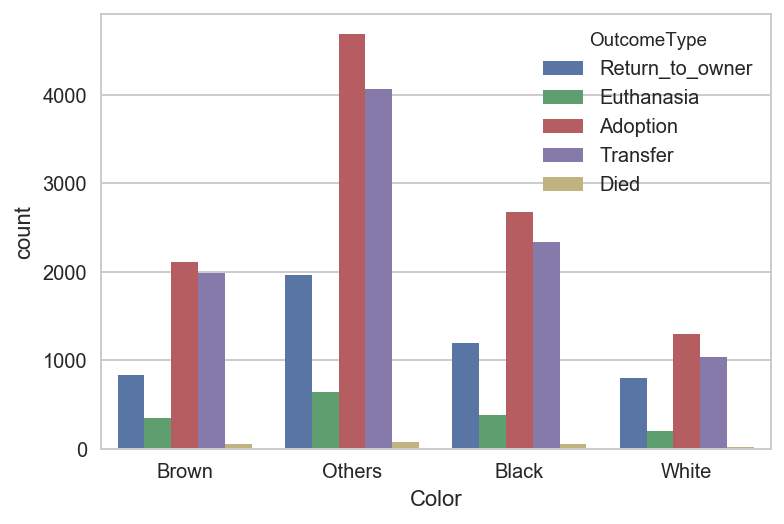

In [67]:
# 색상별로 큰 분포의 차이를 보이진 않아 추후 다른 아이디어를 이용해 볼 예정
sns.countplot(x='Color',data=train, hue='OutcomeType')
plt.show()

동물의 처리결과별 - 특징 통계


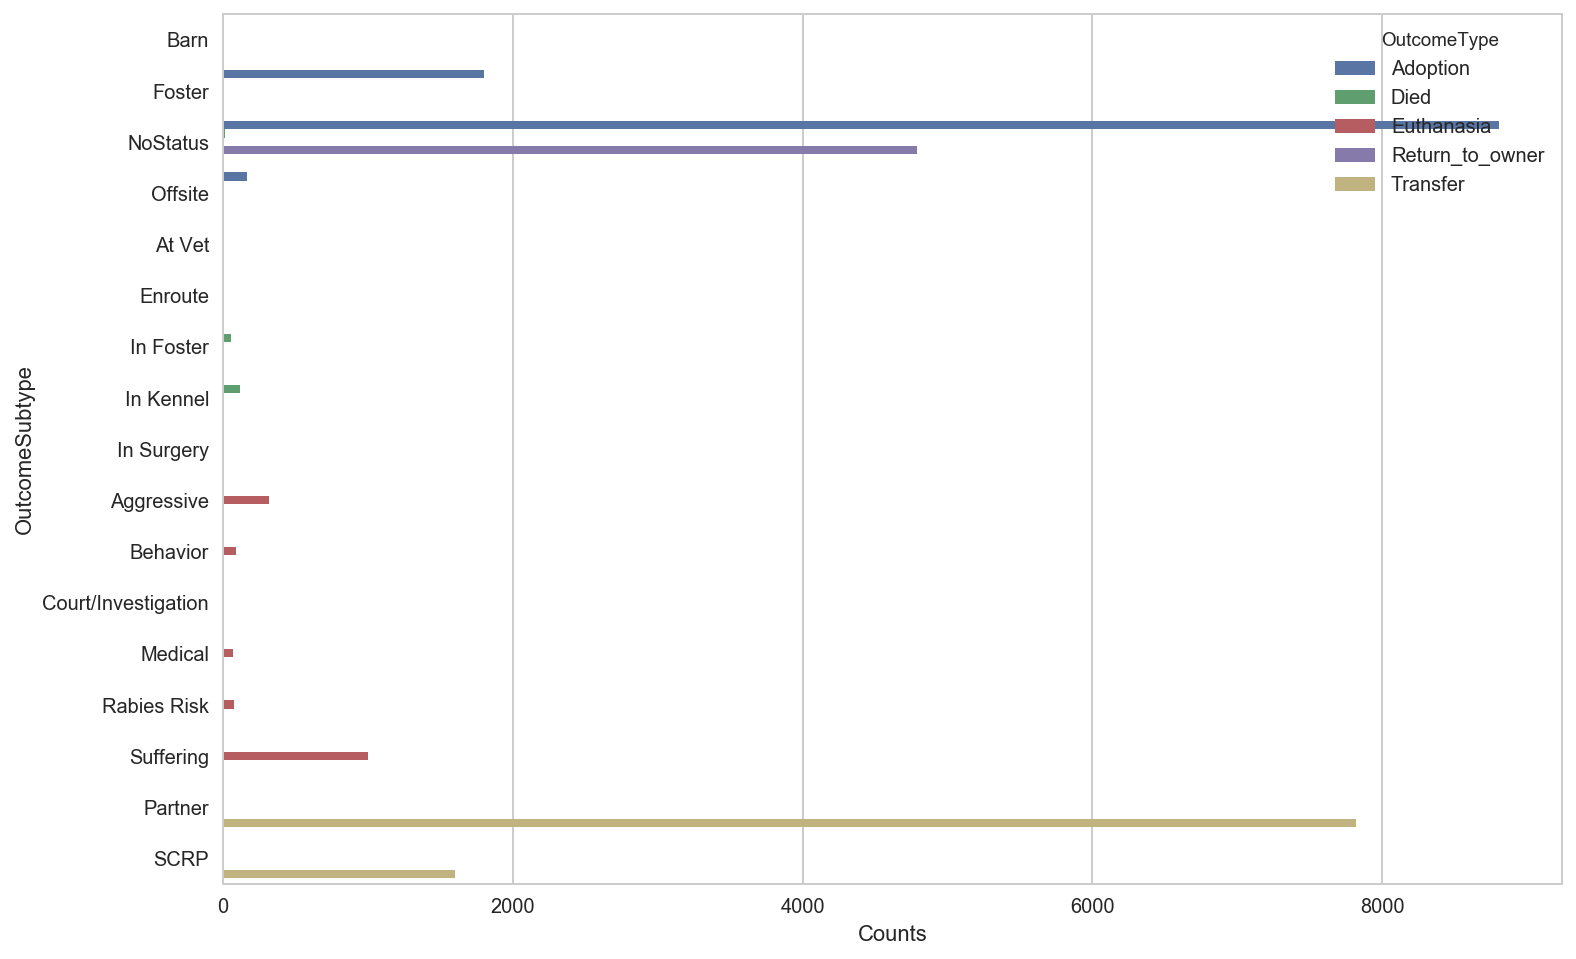

In [16]:
sorted_df = df_train.groupby(["OutcomeType","OutcomeSubtype"]).size().reset_index(name="count")
fig = plt.figure(figsize=(12,8))
ax = sns.barplot(data = sorted_df, x="count", y="OutcomeSubtype", hue="OutcomeType")
ax.set_xlabel('Counts')
ax.set_ylabel('OutcomeSubtype')
print("동물의 처리결과별 - 특징 통계")

### 5-6. Breed

- 개, 고양이의 종류

In [317]:
extra = df_train.groupby('Breed_extra').size().reset_index(name="count").sort_values("count",ascending=False)
extra.head(10)

,Breed_extra,count
0,,10377
396,Chihuahua,2002
939,PitBull,1972
739,LabradorRetriever,1432
604,GermanShepherd,652
1105,Siamese,413
490,Dachshund,405
71,AustralianCattleDog,392
282,Boxer,275
846,MiniaturePoodle,254


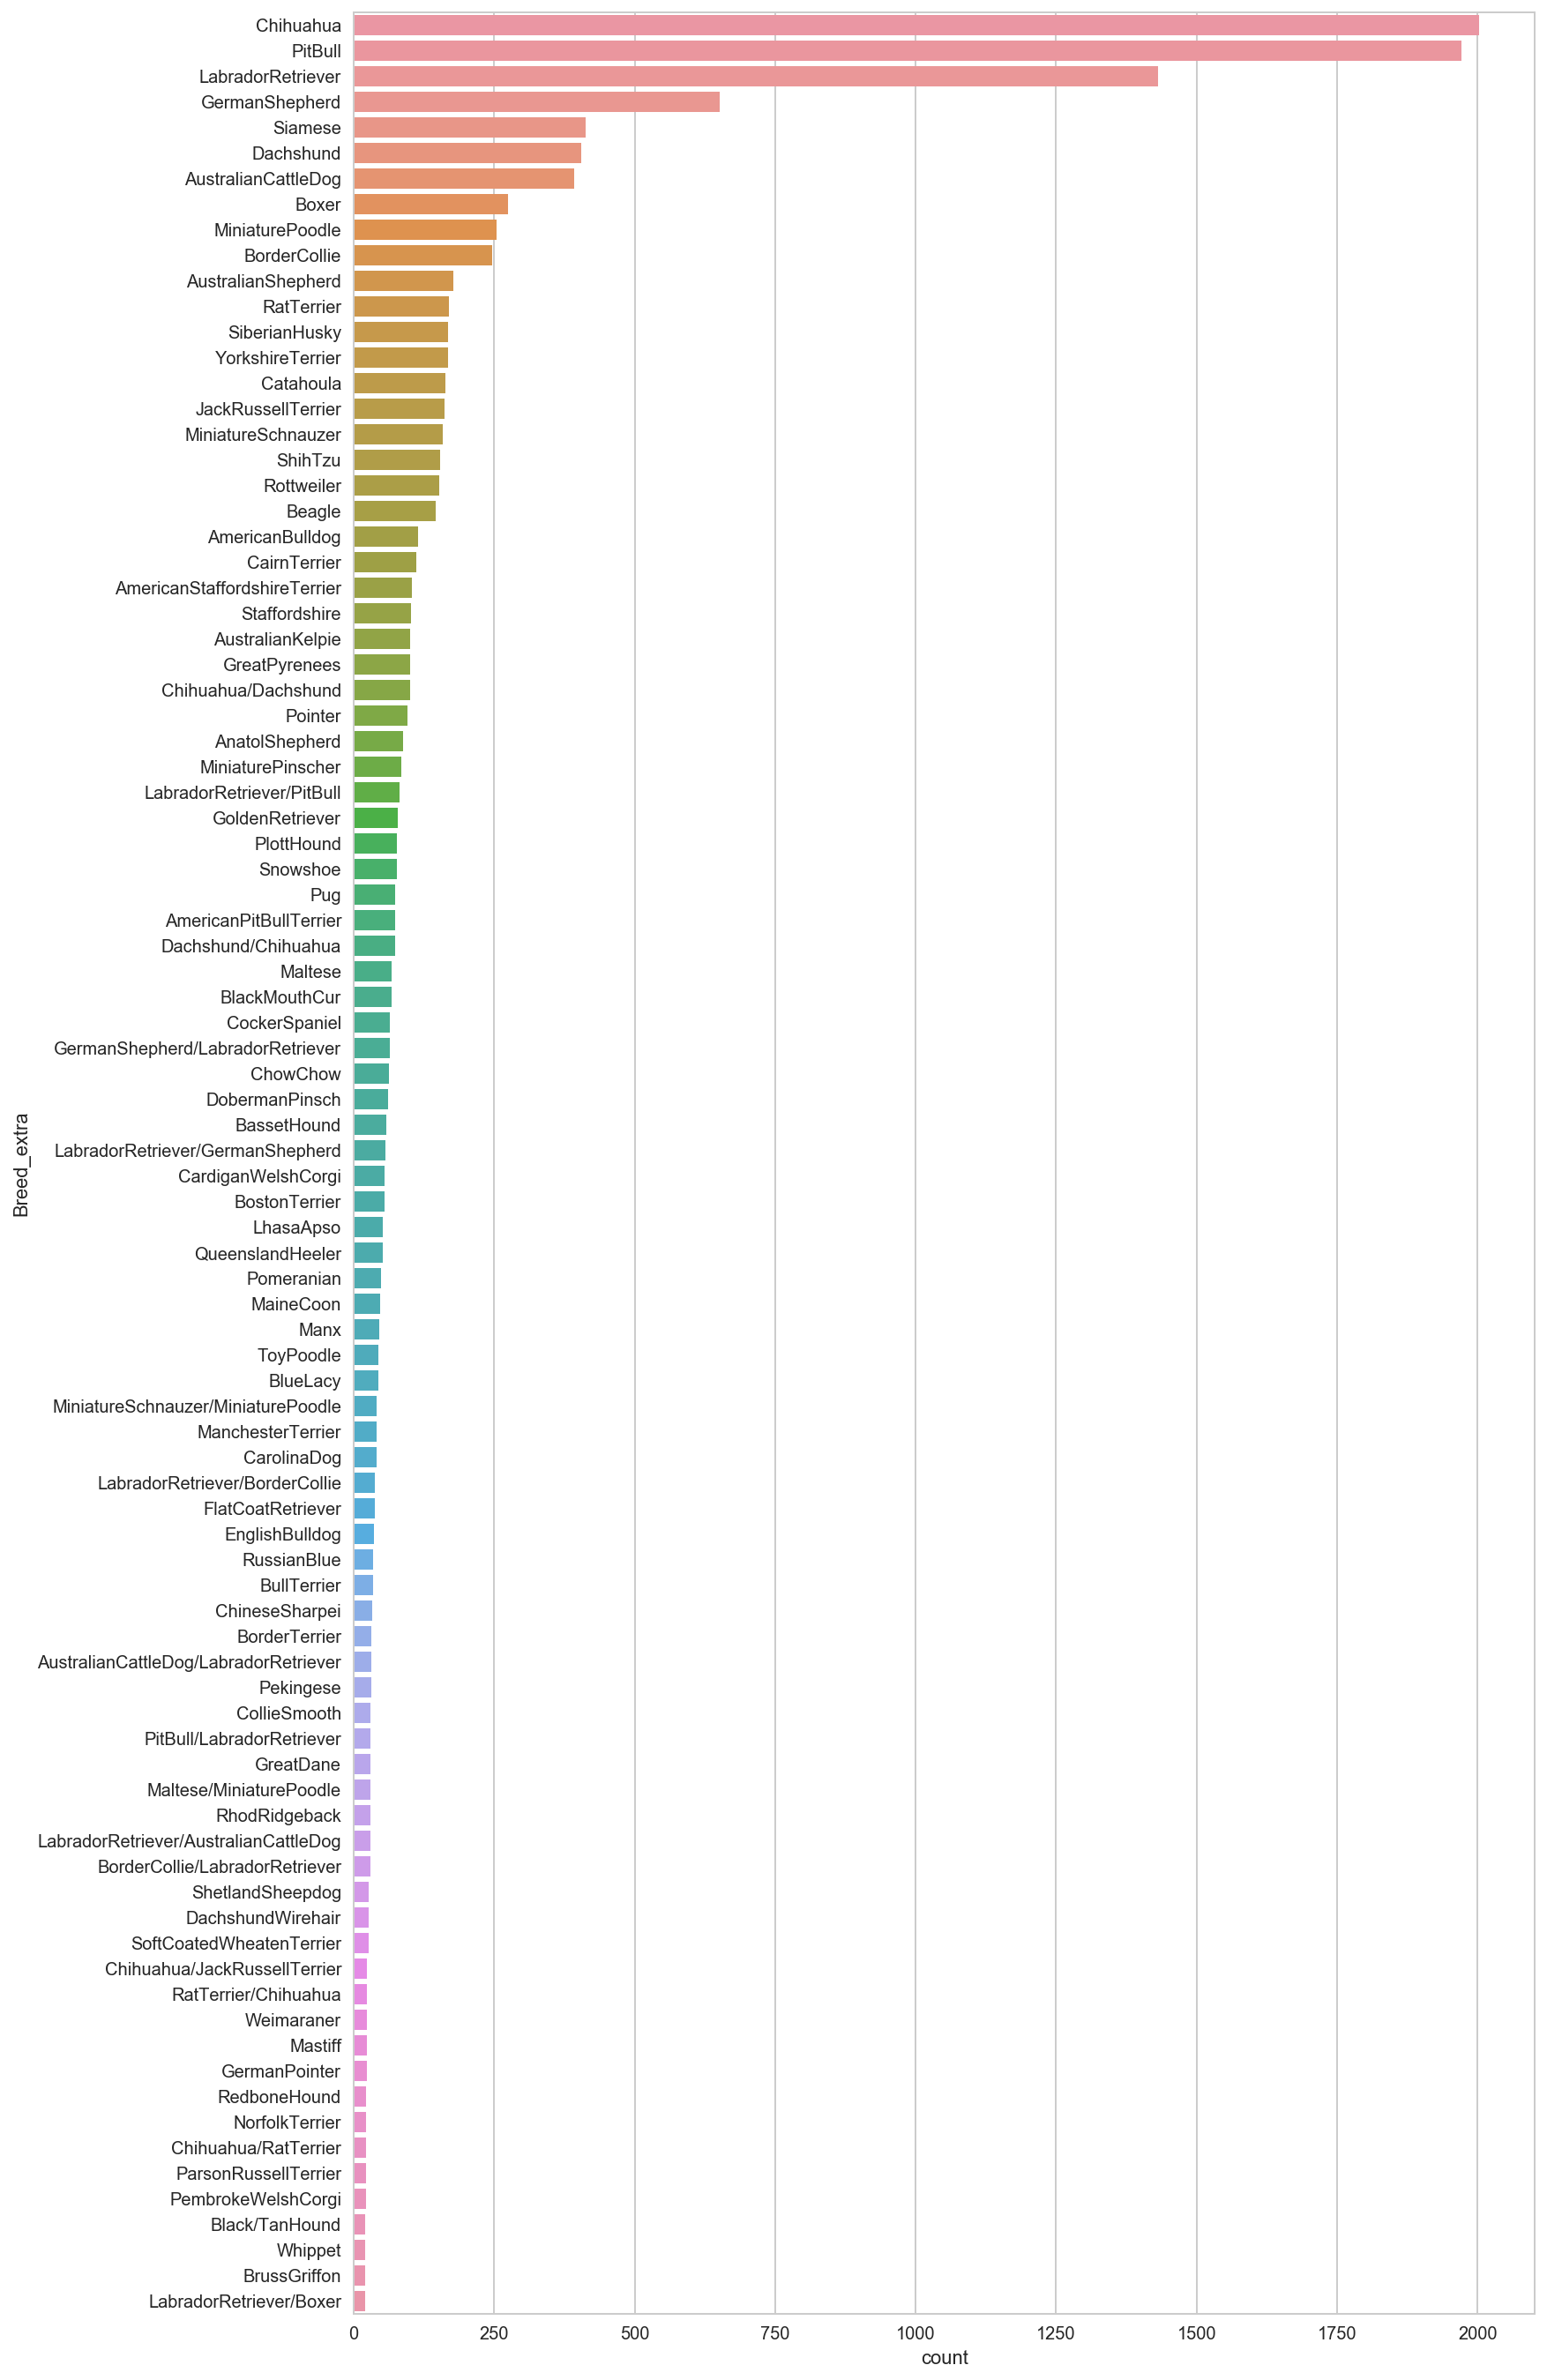

In [320]:
plt.figure(figsize=(12,24))
sns.barplot(x="count",y="Breed_extra",data=extra[(extra["count"]>20)&(extra["count"]<3000)])

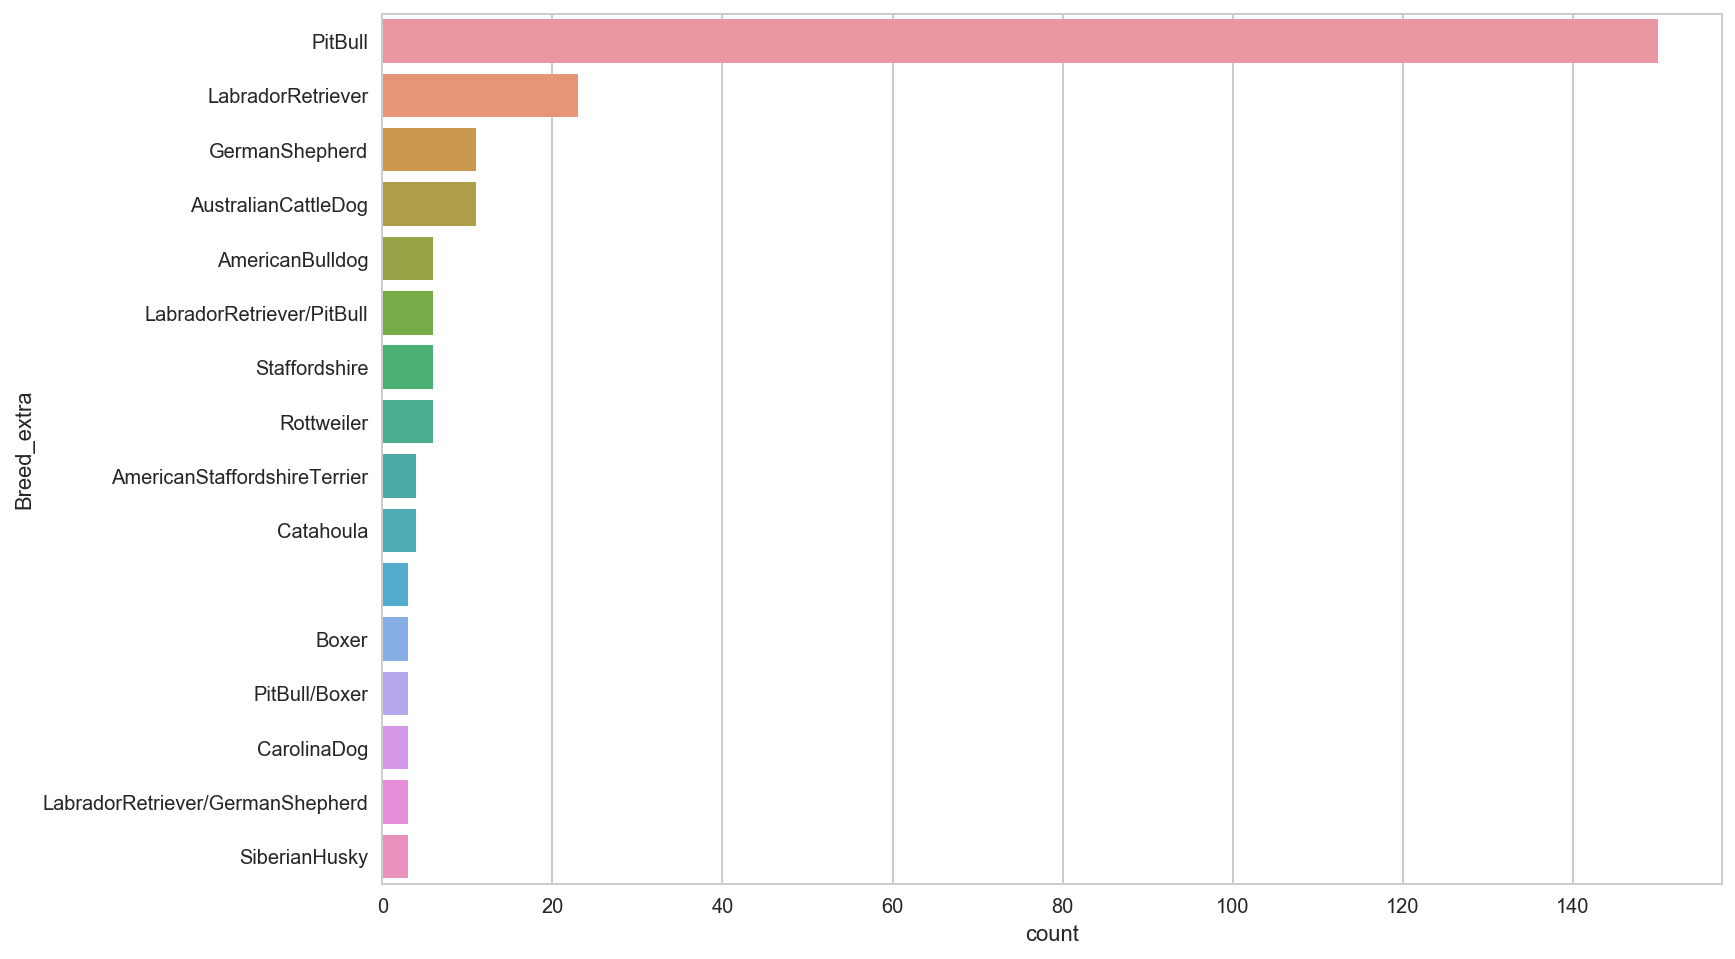

In [321]:
temp = df_train[df_train["OutcomeSubtype"]=="Aggressive"]
temp = temp.groupby('Breed_extra').size().reset_index(name='count').sort_values("count",ascending=False)
plt.figure(figsize=(12,8))
sns.barplot(x='count',y='Breed_extra',data=temp[temp["count"]>2])

# tmp = df_train.copy()
# tmp.Breed_extra[tmp["Breed_extra"].str.contains("PitBull") == True].count()

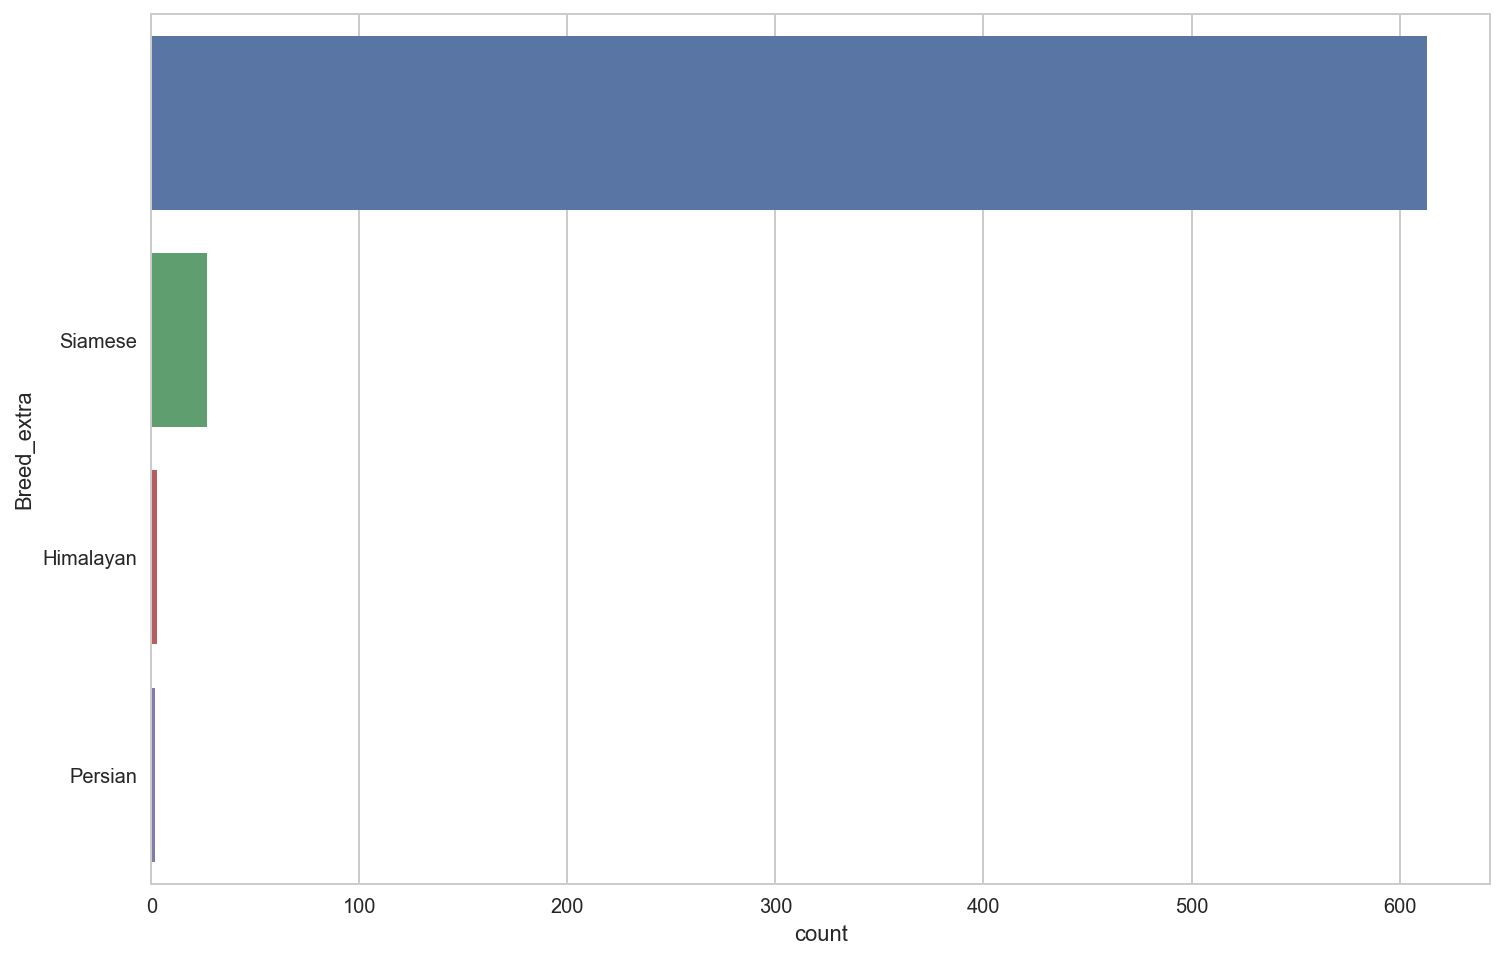

In [30]:
temp = df_train[df_train["OutcomeSubtype"]=="Suffering"]
temp = temp[temp["AnimalType"]=="Cat"]
temp = temp.groupby('Breed_extra').size().reset_index(name='count').sort_values("count",ascending=False)
plt.figure(figsize=(12,8))
sns.barplot(x='count',y='Breed_extra',data=temp[temp["count"]>1])

# tmp = df_train.copy()
# tmp.Breed_extra[tmp["Breed_extra"].str.contains("PitBull") == True].count()

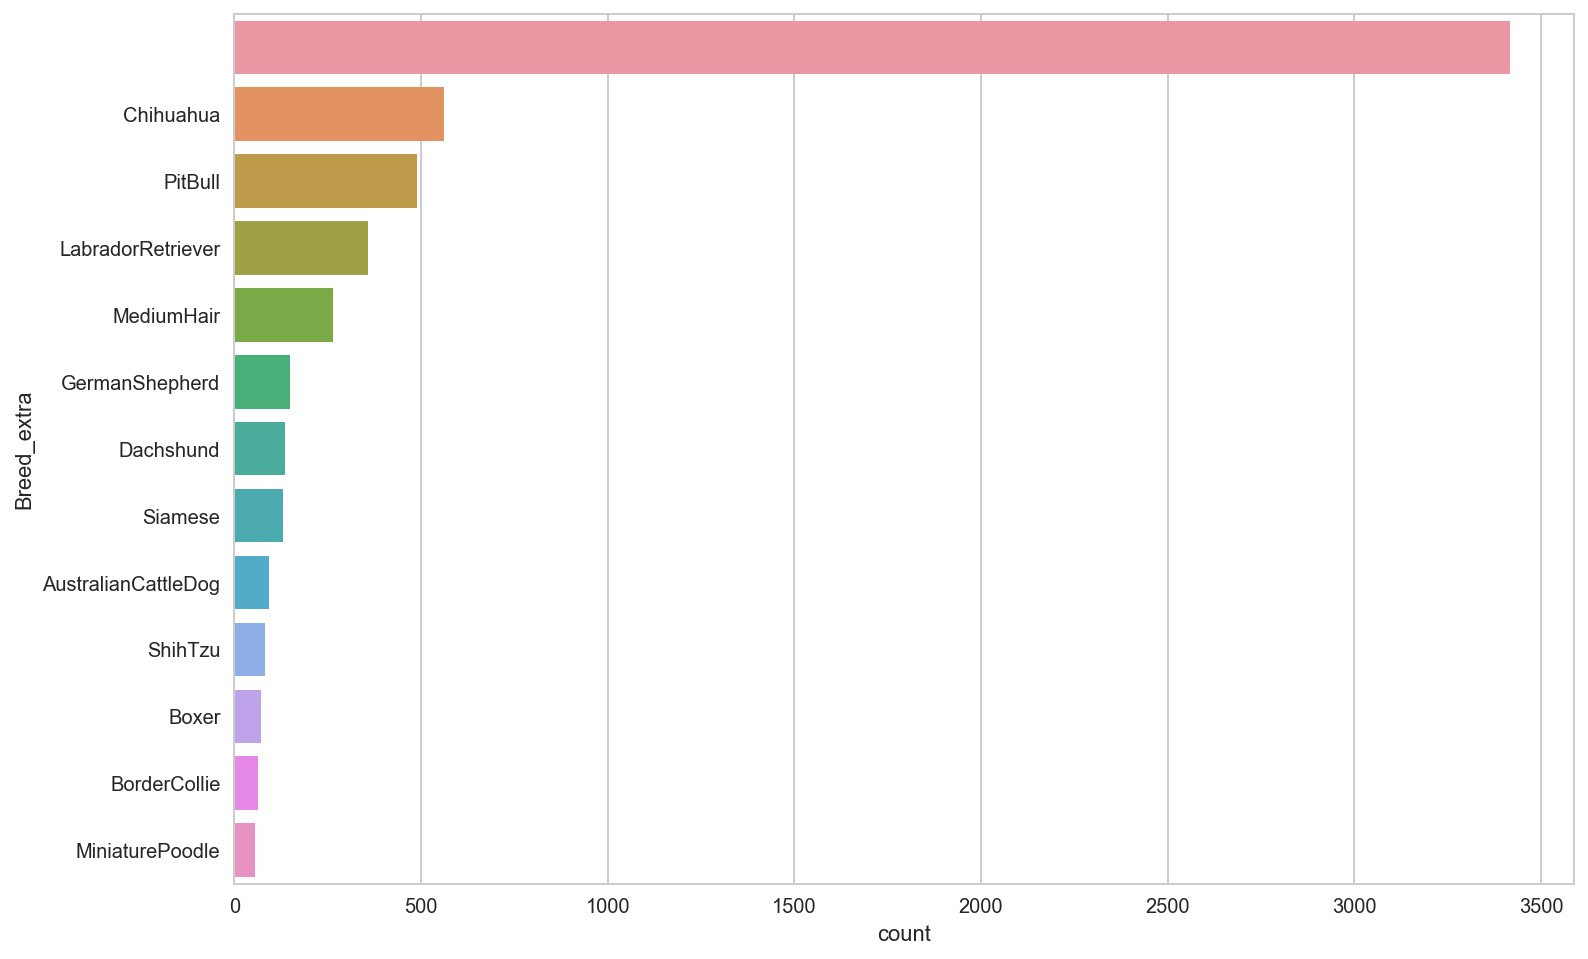

In [17]:
temp = df_train[df_train["OutcomeSubtype"]=="Partner"]
temp = temp.groupby('Breed_extra').size().reset_index(name='count').sort_values("count",ascending=False)
plt.figure(figsize=(12,8))
sns.barplot(x='count',y='Breed_extra',data=temp[temp["count"]>50])

# tmp = df_train.copy()
# tmp.Breed_extra[tmp["Breed_extra"].str.contains("PitBull") == True].count()

[]

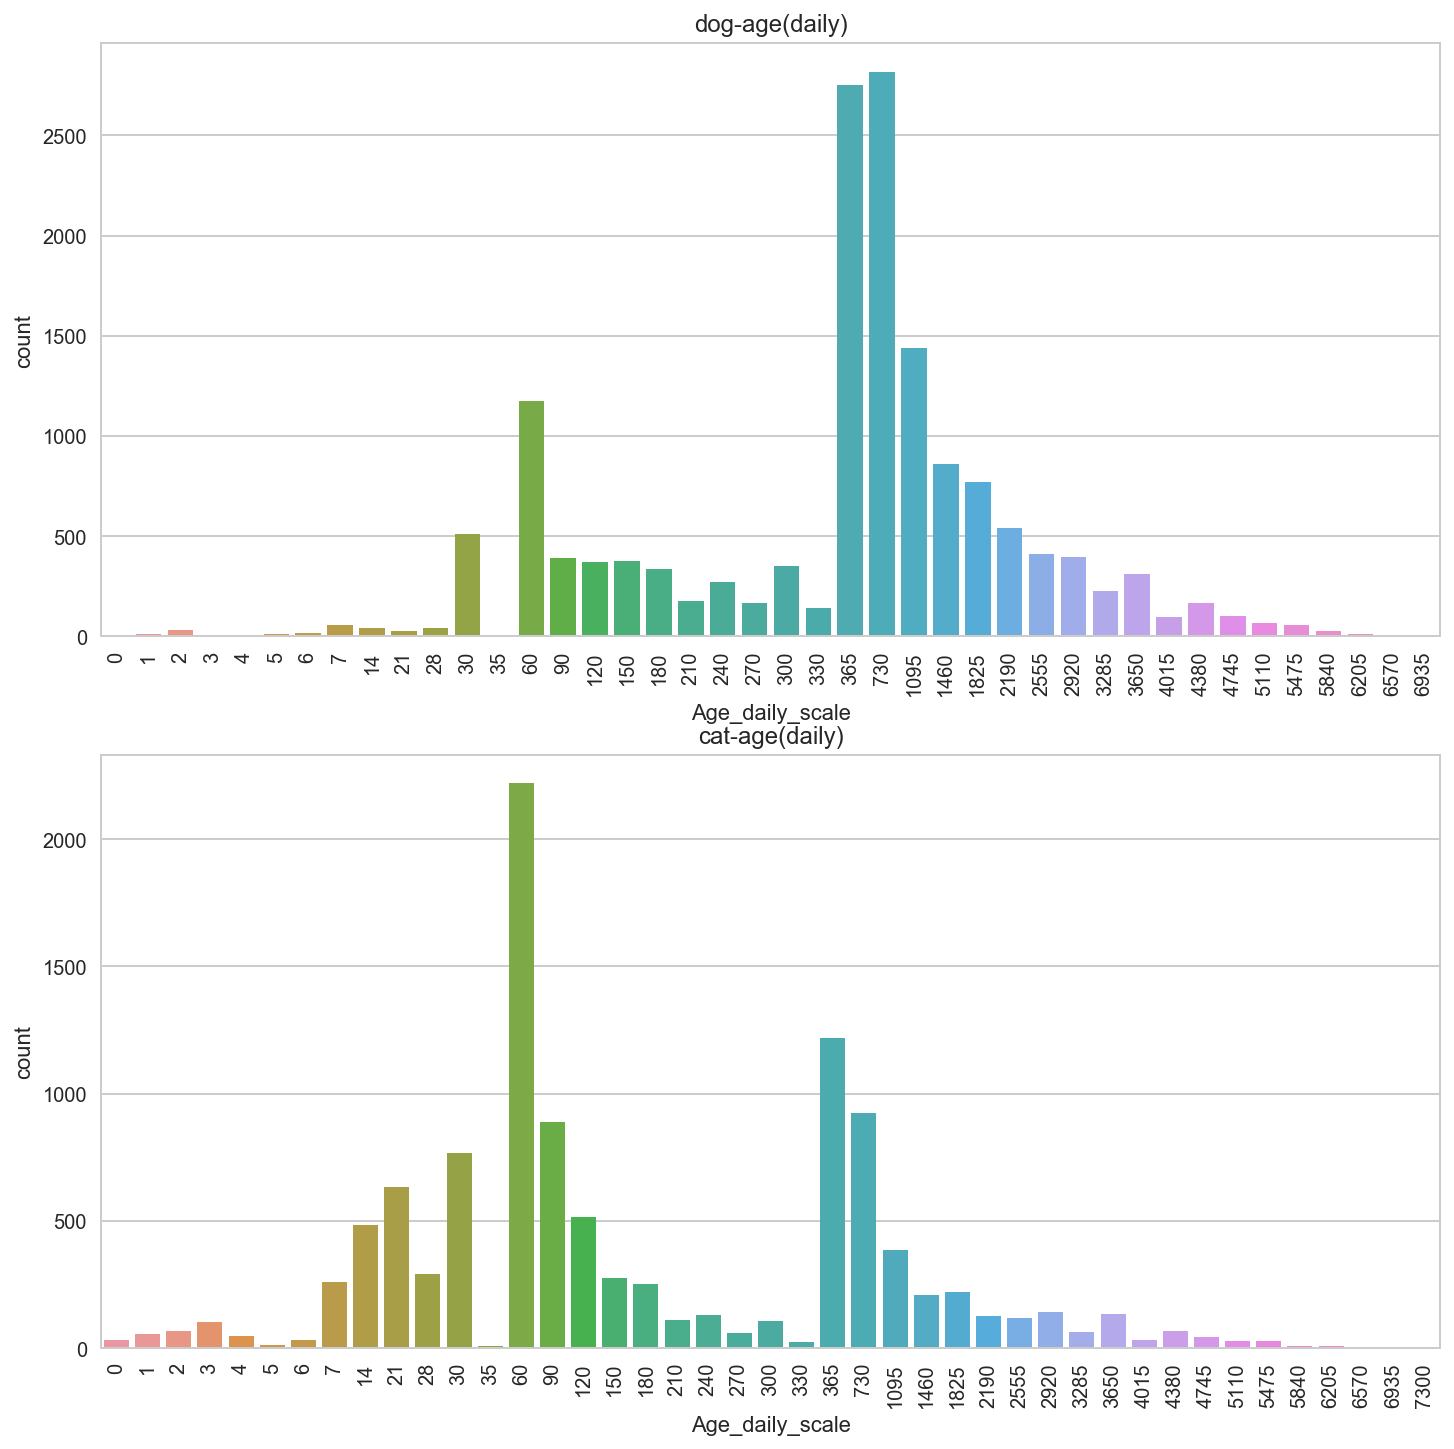

In [82]:
temp1 = df_train[df_train["AnimalType"]=="Dog"]
temp1 = temp1.groupby('Age_daily_scale').size().reset_index(name="count")#.sort_values("count",ascending=False)

temp2 = df_train[df_train["AnimalType"]=="Cat"]
temp2 = temp2.groupby('Age_daily_scale').size().reset_index(name="count")#.sort_values("count",ascending=False)

plt.figure(figsize=(12,12))
plt.subplot(211)
sns.barplot(data=temp1, x='Age_daily_scale',y='count').set_title("dog-age(daily)")
plt.xticks(rotation="vertical")
plt.subplot(212)
sns.barplot(data=temp2, x='Age_daily_scale',y='count').set_title("cat-age(daily)")
plt.xticks(rotation="vertical")
plt.plot()

## 6. Classification Modeling - Cross Validation
0. 나이브 베이지안
1. 의사결정나무
2. 랜덤포레스트
3. XGBoost
4. 앙상블 = 랜덤포레스트 + XGBoost
5. 신경망 - keras

### 분석용 변수 설정

In [765]:
#사전조건 설정 (고양이 or 개)
train_if = train.copy()
# train_if = train[train["AnimalType"]=="Cat"].copy()
# train_if = train[train["AnimalType"]=="Dog"].copy()

In [766]:
# y값 카테고리화
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y = train_if['OutcomeType']
le.fit(y)
y= le.transform(y)
y

array([3, 2, 0, ..., 0, 4, 4], dtype=int64)

In [767]:
le.classes_

array(['Adoption', 'Died', 'Euthanasia', 'Return_to_owner', 'Transfer'], dtype=object)

In [884]:
#분석할 컬럼들
# cols1= ['Name', 'AnimalType', 'SexuponOutcome', 'AgeuponOutcome', 'Color']

#강아지용
cols2=['Name', 'sex_intact', 'sex_unknown', 'sex_mf', 'AnimalType',
       'Age_daily_scale', 'Age_code',
       'Breed_dogM', 'Breed_Mx', 'Breed_Do', 'Breed_Lh', 'Breed_Mh', 'Breed_Sh', 
       'Breed_Pitbull', #'Breed_extra',
       'Time_hour', 'Time_month', 'Time_DOW', 'Time_year', 'Time_weekend', #'Time_day'
#        'Time_operating',
       'Time_season', 'Holidays'
      ]

#고양이용
# cols2=['Name', 'sex_intact', 'sex_unknown', 'sex_mf', 'AnimalType',
#        'Age_daily_scale', 'Age_code',
#        'Breed_dogM', 'Breed_Mx', #'Breed_Do', #'Breed_Lh', 'Breed_Mh', 'Breed_Sh', #'Breed_extra','Breed_Pitbull',
#        'Time_year', 'Time_month', 'Time_DOW', 'Time_day', 'Time_hour',
#        'Time_weekend', 'Time_operating', 'Time_season', 'Holidays']


# df_train2 = preprocessShelter(train_if)
# df_colors2, df_breeds2 = preprocessColorBreed(df_train2,Breed_dev)

# df_OHE = allOneHotEncoder(df_train2,cols2)
df_Ctg = allCategorizer(df_train2,cols2)
# temp.head(20)
# df_train[cols]
df_final = pd.concat([df_Ctg, df_breeds2],axis=1)# ,df_colors2
# cols_f = len(df_final.columns)
df_final = df_final[['Name', 'sex_intact', #'sex_unknown',
                     'sex_mf', 'AnimalType', 'Age_daily_scale',
                     #'Age_code',
                     'Breed_dogM', 'Breed_Mx',
                     'Breed_Lh', 'Breed_Mh', 'Breed_Sh', #'Breed_Do', 
                     'Breed_Pitbull',
                     'Time_hour', 'Time_month', 'Time_DOW', 'Time_year', #'Time_weekend',
                     'Time_season', #'Holidays', 
                     'Breed_RestLife', 'Breed_Life', 'Breed_Agsv', 'Breed_Size',  #'Breed_Acti',
                     'Breed_Smrt', #'Breed_Frdy'
                    ]]
# df_final.columns
#성능이 좋은 세팅
# 고양이 : 

# 강아지 : 카테고리종 한군데 분류
# cols2=['Name', 'AnimalType', 'sex_intact', 'sex_unknown', 'sex_mf',
#        'Age_daily_scale', 'Age_code',
#        'Breed_Do', 'Breed_Mx', 'Breed_Lh', 'Breed_Mh', 'Breed_Sh', 'Breed_dogM','Breed_extra','Breed_Pitbull',
#        'Time_year', 'Time_month', 'Time_DOW', 'Time_day', 'Time_hour',
#        'Time_weekend', 'Time_operating', 'Time_season', 'Holidays']
# df_final = pd.concat([df_Ctg,df_colors2],axis=1)# , df_breeds2
# 결합형

Categorizing start... using  ['Name', 'sex_intact', 'sex_unknown', 'sex_mf', 'AnimalType', 'Age_daily_scale', 'Age_code', 'Breed_dogM', 'Breed_Mx', 'Breed_Do', 'Breed_Lh', 'Breed_Mh', 'Breed_Sh', 'Breed_Pitbull', 'Time_hour', 'Time_month', 'Time_DOW', 'Time_year', 'Time_weekend', 'Time_season', 'Holidays']
0 , 1 , 2 , 3 , 4 , 5 , 6 , 7 , 8 , 9 , 10 , 11 , 12 , 13 , 14 , 15 , 16 , 17 , 18 , 19 , 20 , Complete!


### 의사결정나무 + cv

model creating.., 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11
model testing...
Tree Model1: CV Mean score: 0.608 --- acuraccy score : 0.608
Tree Model2: CV Mean score: 0.608 --- acuraccy score : 0.608
Tree Model3: CV Mean score: 0.608 --- acuraccy score : 0.608
Tree Model4: CV Mean score: 0.618 --- acuraccy score : 0.621
Tree Model5: CV Mean score: 0.634 --- acuraccy score : 0.636
Tree Model6: CV Mean score: 0.651 --- acuraccy score : 0.661
Tree Model7: CV Mean score: 0.666 --- acuraccy score : 0.675
Tree Model8: CV Mean score: 0.671 --- acuraccy score : 0.683
Tree Model9: CV Mean score: 0.672 --- acuraccy score : 0.694
Tree Model10: CV Mean score: 0.667 --- acuraccy score : 0.706
Tree Model11: CV Mean score: 0.662 --- acuraccy score : 0.725


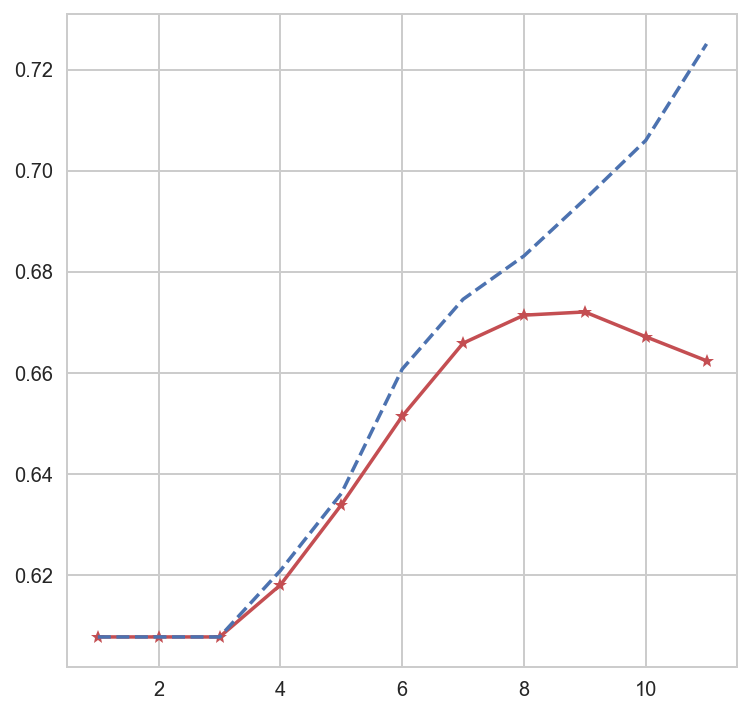

In [885]:
### from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import *
from sklearn.model_selection import cross_val_score, KFold
tree_ls = []
score_ls = []
accur_ls = []

# tree 모델 자동생성 반복문
print("model creating..",end="")
for i in range(1,12):
    tree = DecisionTreeClassifier(criterion='entropy', max_depth=i, random_state=0).fit(df_final,y)
    print(",",i,end="")
    tree_ls.append(tree)

# 모델 CV돌리기
print("\nmodel testing...")
for i, model in enumerate(tree_ls):
    scores = cross_val_score(model, df_final, y,cv=10)
    accuracy = accuracy_score(y,model.predict(df_final))
    print(("Tree Model{0:d}: CV Mean score: {1:.3f}").format(i+1,np.mean(scores)), end="")
    print((" --- acuraccy score : {0:.3f}").format(accuracy)) # Kfold 안했을때 비교
    score_ls.append(np.mean(scores))
    accur_ls.append(accuracy)
    
# 플롯팅 
plt.figure(figsize=(6,6))
plt.plot(range(1,len(score_ls)+1),list(score_ls),'-*r')
plt.plot(range(1,len(accur_ls)+1),list(accur_ls),'--b')
plt.show()
# 고양이 : 0.787 - depth : 5
# 강아지 : 0.583 - depth : 9 (Breed 간략화) --> 0.585 - depth : 8 (Breed 세분화)
# 결합기록 : 0.673 - depth : 9 -(Color 제거)

In [454]:
# plot_decision_regions(df_data,df_target, tree1, "Depth 1")
# plt.show()
Tree = DecisionTreeClassifier(criterion='entropy', max_depth=8, random_state=0).fit(df_final,y)

from sklearn.metrics import *
score = cross_val_score(Tree, df_final, y,cv=10)
print("- CV_Score : {1:.3f}".format(i+1,np.mean(score)))
print("- Accuracy_Score : ", accuracy_score(y,Tree.predict(df_final)))
print("- Confusion_Matrix \n",confusion_matrix(y, Tree.predict(df_final)))
print(classification_report(y, Tree.predict(df_final), target_names=["Adoption","Died","Euthanasia","Return_to_owner","Transfer"]))
# print("- Log-loss :", log_loss(y,treeA.predict(df_final)))

- CV_Score : 0.671
- Accuracy_Score :  0.683863967975
- Confusion_Matrix 
 [[9049    3   11 1177  529]
 [  23   33   13   10  118]
 [ 247    4  382  336  586]
 [1912    1   57 2395  421]
 [1929    5  134  934 6420]]
                 precision    recall  f1-score   support

       Adoption       0.69      0.84      0.76     10769
           Died       0.72      0.17      0.27       197
     Euthanasia       0.64      0.25      0.36      1555
Return_to_owner       0.49      0.50      0.50      4786
       Transfer       0.80      0.68      0.73      9422

    avg / total       0.69      0.68      0.68     26729



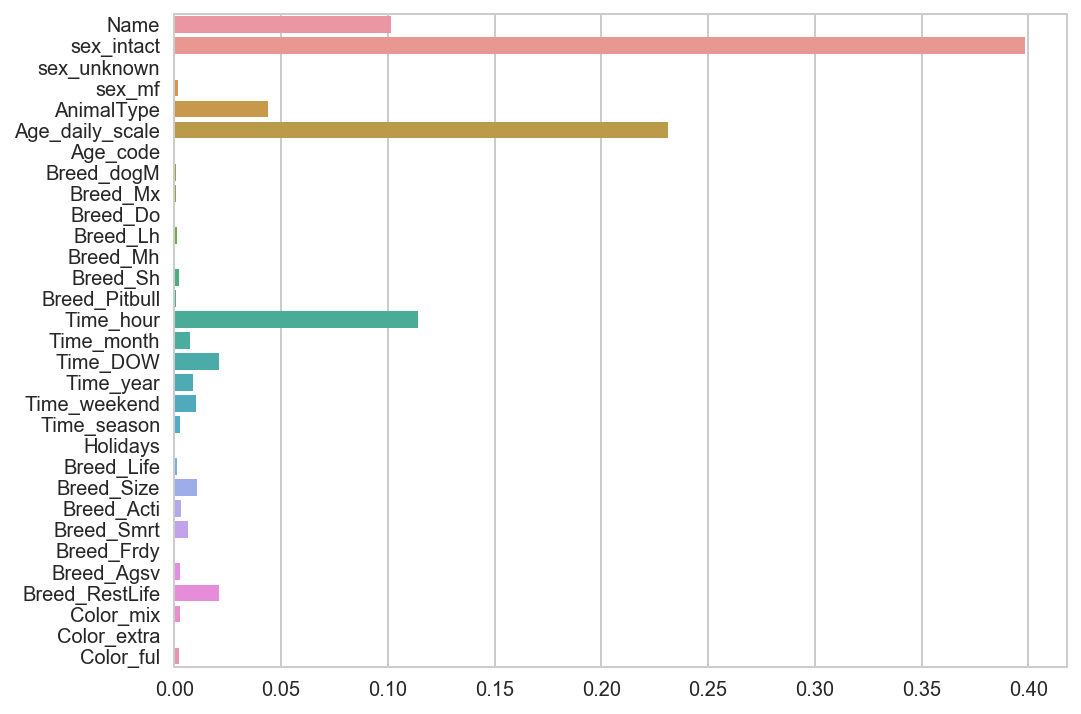

In [785]:
###### 피쳐 중요도
importance = tree_ls[7].feature_importances_
plt.figure(figsize=(8,6))
sns.barplot(y=df_final.columns[:31], x=importance[:31])
# importance

### 랜덤포레스트 + cv

In [776]:
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import *
from sklearn.model_selection import cross_val_score, KFold
RF_ls = []
score_ls = []
accur_ls = []

# randomforest 모델 자동생성 반복문
print("RFmodel creating..",end="")
for i in range(6,20):
    RF = RandomForestClassifier(n_estimators=250, criterion='entropy', max_depth=i, random_state=0).fit(df_final,y)
    print(",",i,end="")
    RF_ls.append(RF)

# 모델 CV돌리기
print("\nmodel testing...")
for i, model in enumerate(RF_ls):
    scores = cross_val_score(model, df_final, y,cv=10)
    accuracy = accuracy_score(y,model.predict(df_final))
    print(("RandomForest Model{0:d}: CV Mean score: {1:.3f}").format(i+1,np.mean(scores)), end="")
    print((" --- acuraccy score : {0:.3f}").format(accuracy)) # Kfold 안했을때 비교
    score_ls.append(np.mean(scores))
    accur_ls.append(accuracy)
    
# 플롯팅 
plt.figure(figsize=(6,6))
plt.plot(range(1,len(score_ls)+1),list(score_ls),'-*r')
plt.plot(range(1,len(accur_ls)+1),list(accur_ls),'--b')
plt.show()
#----------------------------------------------------------------------
Ex_ls = []
score_ls = []
accur_ls = []
print("EXmodel creating..",end="")
for i in range(5,17):
    Ex = ExtraTreesClassifier(n_estimators=15, criterion='entropy', max_depth=i, random_state=0).fit(df_final,y)
    print(",",i,end="")
    Ex_ls.append(Ex)

# 모델 CV돌리기
print("\nmodel testing...")
for i, model in enumerate(Ex_ls):
    scores = cross_val_score(model, df_final, y,cv=10)
    accuracy = accuracy_score(y,model.predict(df_final))
    print(("ExtraTree Model{0:d}: CV Mean score: {1:.3f}").format(i+1,np.mean(scores)), end="")
    print((" --- acuraccy score : {0:.3f}").format(accuracy)) # Kfold 안했을때 비교
    score_ls.append(np.mean(scores))
    accur_ls.append(accuracy)
    
# 플롯팅 
plt.figure(figsize=(6,6))
plt.plot(range(1,len(score_ls)+1),list(score_ls),'-*r')
plt.plot(range(1,len(accur_ls)+1),list(accur_ls),'--b')
plt.show()
#고양이 cv최고기록 : 0.809 - n-esti:100// depth:20// (Breed 간략화) --> 0. Breed세분화
#강아지 cv최고기록 : 0.607 - n-esti:100// depth:14// (Breed 간략화) --> 0.610 n-esti:200/depth:15 (Breed세분화)
#종합 cv최고기록 : 0.690 - n-esti:250// depth:18// obj:'multi:softprob'

RFmodel creating.., 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19
model testing...
RandomForest Model1: CV Mean score: 0.648 --- acuraccy score : 0.649
RandomForest Model2: CV Mean score: 0.655 --- acuraccy score : 0.661
RandomForest Model3: CV Mean score: 0.659 --- acuraccy score : 0.671
RandomForest Model4: CV Mean score: 0.667 --- acuraccy score : 0.684
RandomForest Model5: CV Mean score: 0.672 --- acuraccy score : 0.700
RandomForest Model6: CV Mean score: 0.676 --- acuraccy score : 0.718
RandomForest Model7: CV Mean score: 0.679 --- acuraccy score : 0.743
RandomForest Model8: CV Mean score: 0.681 --- acuraccy score : 0.773
RandomForest Model9: CV Mean score: 0.683 --- acuraccy score : 0.807
RandomForest Model10: CV Mean score: 0.685 --- acuraccy score : 0.845
RandomForest Model11: CV Mean score: 0.685 --- acuraccy score : 0.882
RandomForest Model12: CV Mean score: 0.685 --- acuraccy score : 0.921


KeyboardInterrupt: 

In [ ]:
# plot_decision_regions(df_data,df_target, tree1, "Depth 1")
# plt.show()
RF = RandomForestClassifier(n_estimators = 250, criterion='entropy', max_depth=21, random_state=0).fit(df_final,y)

from sklearn.metrics import *
score = cross_val_score(RF, df_final, y,cv=10)
print("- CV_Score : {1:.3f}".format(i+1,np.mean(score)))
print("- Accuracy_Score : ", accuracy_score(y,RF.predict(df_final)))
print("- Confusion_Matrix \n",confusion_matrix(y, RF.predict(df_final)))
print(classification_report(y, RF.predict(df_final), target_names=["Adoption","Died","Euthanasia","Return_to_owner","Transfer"]))
# print("- Log-loss :", log_loss(y,RF.predict(df_final)))

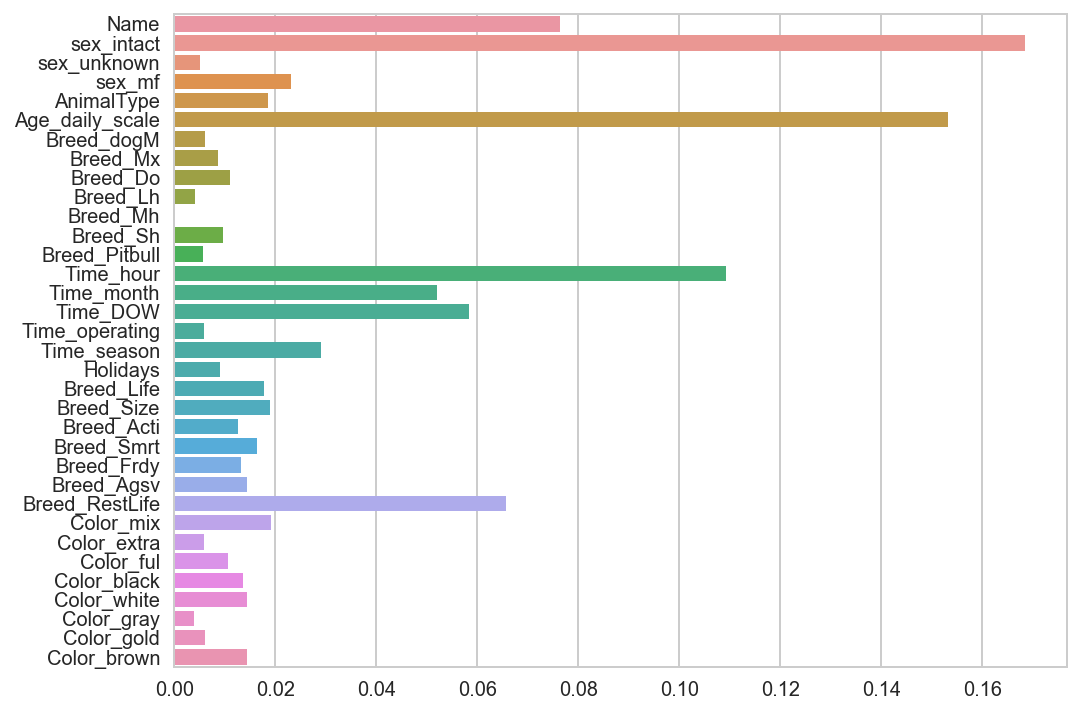

In [777]:
###### 피쳐 중요도
importance = RF_ls[9].feature_importances_
plt.figure(figsize=(8,6))
sns.barplot(y=df_final.columns[:], x=importance[:])
# importance

### XGBoost + cv (느려서 중단)

In [256]:
import xgboost

model creating.., 5, 7, 9, 11, 13, 15
model testing...
XGB Model1: Mean score: 0.689 --- acuraccy score : 0.711
XGB Model2: Mean score: 0.694 --- acuraccy score : 0.743
XGB Model3: Mean score: 0.697 --- acuraccy score : 0.792
XGB Model4: Mean score: 0.699 --- acuraccy score : 0.852
XGB Model5: Mean score: 0.700 --- acuraccy score : 0.902
XGB Model6: Mean score: 0.699 --- acuraccy score : 0.945


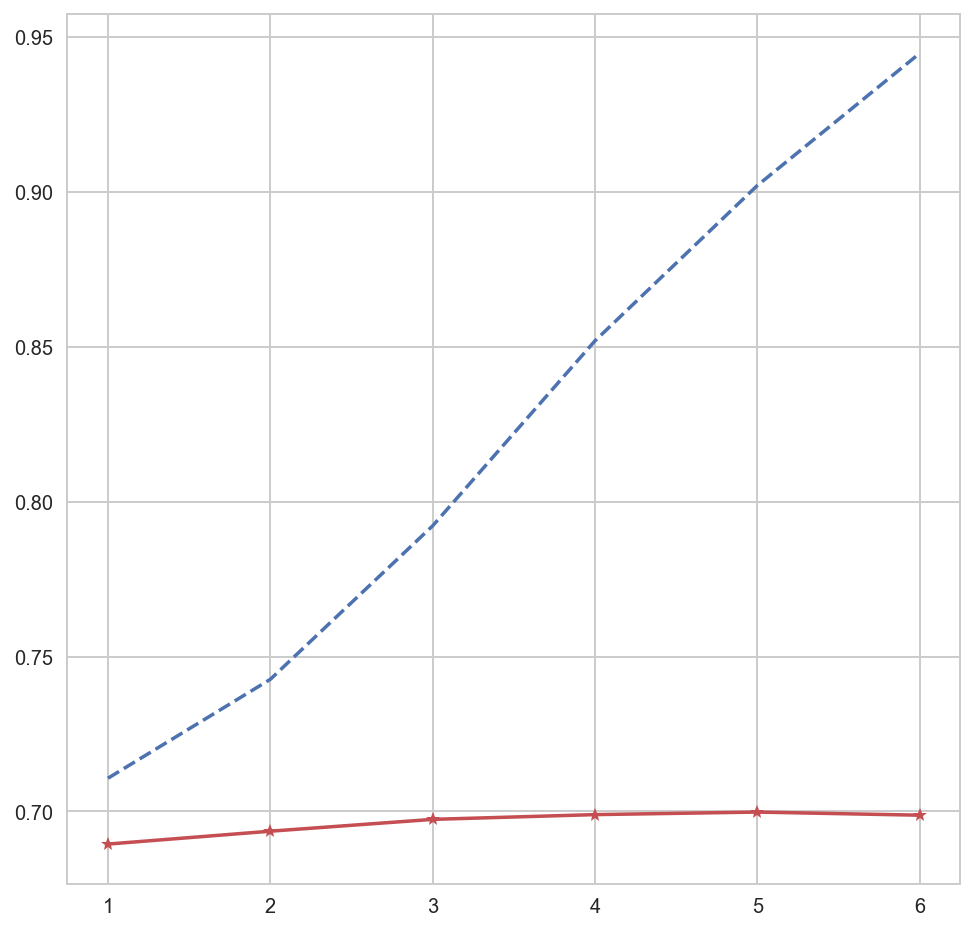

In [242]:
from sklearn.model_selection import cross_val_score, KFold
import xgboost
model_ls = []
score_ls = []
accur_ls = []

# XGB 모델 자동생성 반복문
print("model creating..",end="")
for i in range(5,16,2):
    XGB = xgboost.XGBClassifier(n_estimators=50, learning_rate=0.2, max_depth=i, random_state=0).fit(df_final,y)
    print(",",i,end="")
    model_ls.append(XGB)

# 모델 CV돌리기
print("\nmodel testing...")
for i, model in enumerate(model_ls):
    scores = cross_val_score(model, df_final, y,cv=10)
    accuracy = accuracy_score(y,model.predict(df_final))
    print(("XGB Model{0:d}: Mean score: {1:.3f}").format(i+1,np.mean(scores)), end="")
    print((" --- acuraccy score : {0:.3f}").format(accuracy)) # Kfold 안했을때 비교
    score_ls.append(np.mean(scores))
    accur_ls.append(accuracy)
    
# 플롯팅 
plt.figure(figsize=(8,8))
plt.plot(range(1,len(score_ls)+1),list(score_ls),'-*r')
plt.plot(range(1,len(accur_ls)+1),list(accur_ls),'--b')
plt.show()

In [243]:
from sklearn.metrics import *

XGB_model = xgboost.XGBClassifier(n_estimators=50, learning_rate=0.2, max_depth=14, random_state=0).fit(df_final,y)

scores = cross_val_score(XGB_model, df_final, y,cv=10)
y_pred = XGB_model.predict(df_final)
accuracy = accuracy_score(y,y_pred)
print(("XGB Model{0:d}: Mean score: {1:.3f}").format(i+1,np.mean(scores)), end="")
print((" --- acuraccy score : {0:.3f}").format(accuracy)) # Kfold 안했을때 비교

print("- Confusion_Matrix \n",confusion_matrix(y, XGB_model.predict(df_final)))
print(classification_report(y, y_pred, target_names=["Adoption","Died","Euthanasia","Return_to_owner","Transfer"]))
print("- Log-loss :", log_loss(y,y_pred))

XGB Model6: Mean score: 0.699 --- acuraccy score : 0.926
- Confusion_Matrix 
 [[10268     0     2   331   168]
 [    8   181     0     5     3]
 [   26     0  1447    38    44]
 [  510     0     0  4165   111]
 [  357     0     2   375  8688]]
                 precision    recall  f1-score   support

       Adoption       0.92      0.95      0.94     10769
           Died       1.00      0.92      0.96       197
     Euthanasia       1.00      0.93      0.96      1555
Return_to_owner       0.85      0.87      0.86      4786
       Transfer       0.96      0.92      0.94      9422

    avg / total       0.93      0.93      0.93     26729



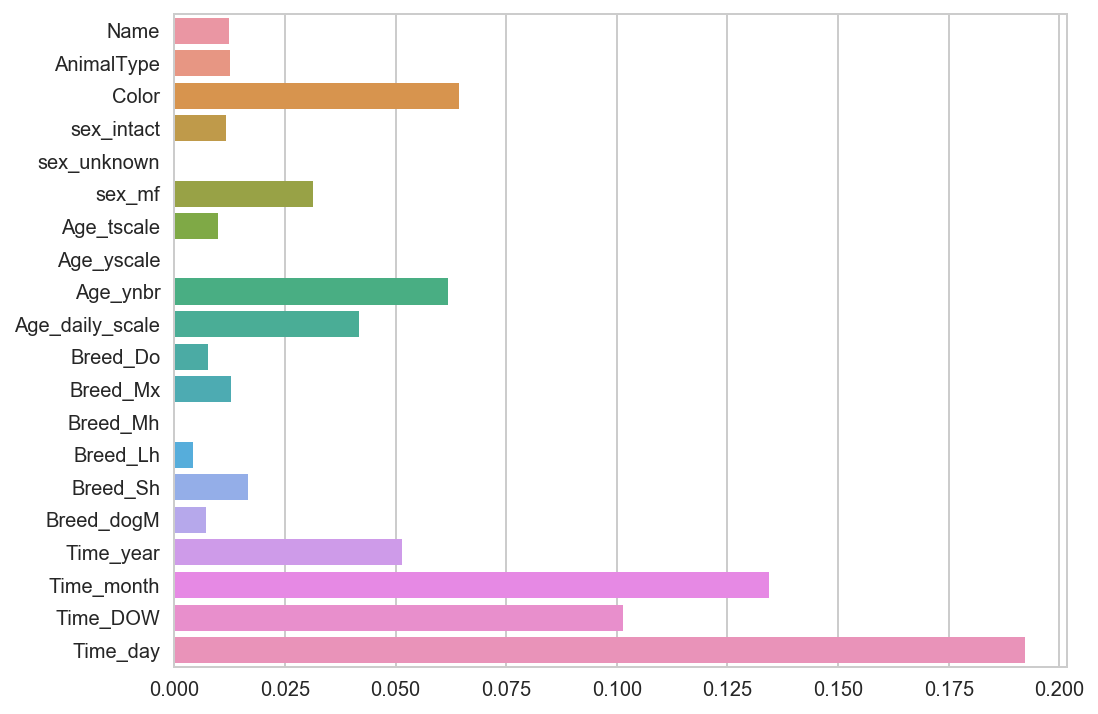

In [245]:
# 피쳐 중요도
importance = XGB_model.feature_importances_
plt.figure(figsize=(8,6))
sns.barplot(y=df_final.columns[:20], x=importance[:20])
# importance

### LightGBM 모델 + cv

model creating. max_depth==>, 16
model testing...
LGB Model1: CV Mean score: 0.695 --- acuraccy score : 0.771


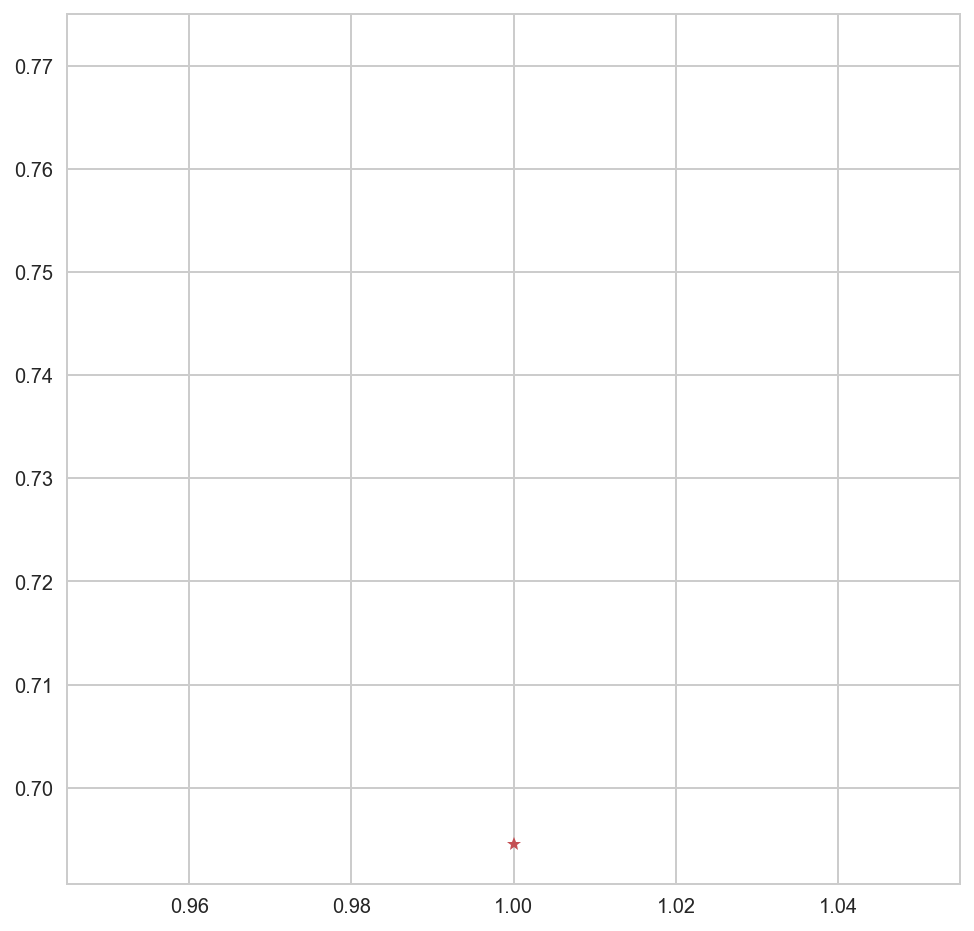

In [1161]:
from sklearn.model_selection import cross_val_score, KFold
import lightgbm as lgb

model_ls = []
score_ls = []
accur_ls = []

# XGB 모델 자동생성 반복문
print("model creating. max_depth==>",end="") # max_depth
for i in range(16,17,1):
    LGB = lgb.LGBMClassifier(boosting_type="gbdt", n_estimators=250, objective="multi:softprob",
                             max_depth=i, random_state=0).fit(df_final,y) #max_depth=i
#     LGB = lgb.LGBMClassifier(boosting_type="gbdt", n_estimators=250, objective="multi:softprob", nrounds=125, verbose=1, eta=0.2,
#                                colsample_bytree=0.8, eval_metric="mlogloss", subsample_for_bin=50000, learning_rate=0.2,
#                                subsample=0.75, max_depth=i, random_state=0).fit(df_final,y)
    
    print(",",i,end="")
    model_ls.append(LGB)

# 모델 CV돌리기
print("\nmodel testing...")
for i, model in enumerate(model_ls):
    scores = cross_val_score(model, df_final, y,cv=10)
    accuracy = accuracy_score(y,model.predict(df_final))
    print(("LGB Model{0:d}: CV Mean score: {1:.3f}").format(i+1,np.mean(scores)), end="")
    print((" --- acuraccy score : {0:.3f}").format(accuracy)) # Kfold 안했을때 비교
    score_ls.append(np.mean(scores))
    accur_ls.append(accuracy)
    
# 플롯팅 
plt.figure(figsize=(8,8))
plt.plot(range(1,len(score_ls)+1),list(score_ls),'-*r')
plt.plot(range(1,len(accur_ls)+1),list(accur_ls),'--b')
plt.show()

#고양이 cv최고기록 : 0.821 - n-esti:250/ depth:12/ obj:'multi:softprob'/
#강아지 cv최고기록 : 0.618 - n-esti:200/ depth:-1/ obj:'multi:softprob'(종간략화)// 0.619 nesti:250/depth:3(종세분화)
#종합 cv최고기록 : 0.700 - n-esti:500/ depth:-1/ obj:'multi:softprob'/
# 직전최고기록 0.695 - 0.0 =  ___ nesti = 500/depth = 12,15,18
# 캐글 최고기록--> #0.696 - 0.794 = 98 ___ nesti = 350/depth = 11,17,18
                #0.695 - 0.770 = 72 ___ nesti = 250/depth = 16
                #0.694 - 0.741 = 45 ___ nesti = 150/depth = 12
                #0.694 - 0.729 = 35 ___ nesti = 120/depth = 13
                #0.694 - 0.723 = 29 ___ nesti = 100/depth = 15 #예제그래프로 활용가능할듯 
                #0.693 - 0.716 = 23 ___ nesti = 80/depth = 15
                #0.692 - 0.714 = 22 ___ nesti = 70/depth = 11
                #0.690 - 0.706 = 16 ___ nesti = 50/depth = 16

In [539]:
import lightgbm as lgb 

from sklearn.metrics import *

LGB_model = lgb.LGBMClassifier(boosting_type="gbdt", n_estimators=150, objective="multi:softprob",
                                max_depth=-1, random_state=0).fit(df_final,y)

scores = cross_val_score(LGB_model, df_final, y,cv=10)
y_pred = LGB_model.predict(df_final)
accuracy = accuracy_score(y,y_pred)
print(("LGB Model{0:d}: Mean score: {1:.3f}").format(i+1,np.mean(scores)), end="")
print((" --- acuraccy score : {0:.3f}").format(accuracy)) # Kfold 안했을때 비교

print("- Confusion_Matrix \n",confusion_matrix(y, y_pred))
print(classification_report(y, y_pred, target_names=["Adoption","Died","Euthanasia","Return_to_owner","Transfer"]))
# print("- Log-loss :", log_loss(y,y_pred))


LGB Model14: Mean score: 0.695 --- acuraccy score : 0.756
- Confusion_Matrix 
 [[9357    0   13  852  547]
 [   6  111    5    2   73]
 [ 145    0  647  243  520]
 [1471    0   26 2839  450]
 [1385    0   75  715 7247]]
                 precision    recall  f1-score   support

       Adoption       0.76      0.87      0.81     10769
           Died       1.00      0.56      0.72       197
     Euthanasia       0.84      0.42      0.56      1555
Return_to_owner       0.61      0.59      0.60      4786
       Transfer       0.82      0.77      0.79      9422

    avg / total       0.76      0.76      0.75     26729



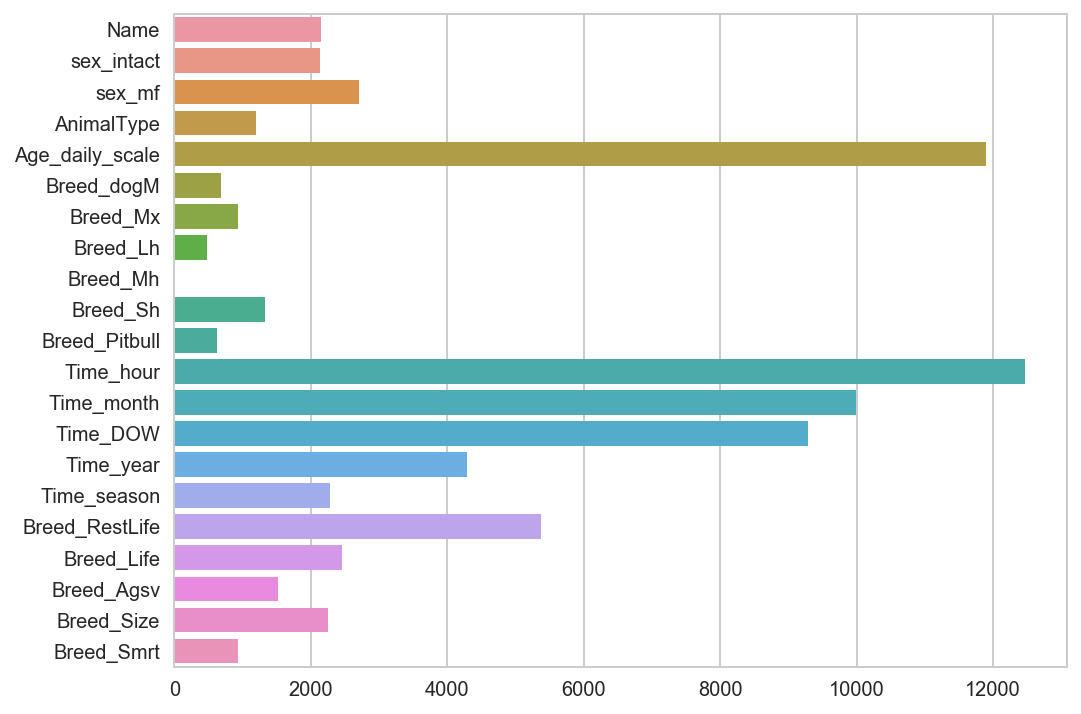

In [995]:
## 피쳐 중요도
importance = model_ls[10].feature_importances_
plt.figure(figsize=(8,6))
sns.barplot(y=df_final.columns[:31], x=importance[:31])
# importance

### 앙상블에 앙상블 얹기 - 랜덤포레스트 + LightGBM 

In [51]:
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import cross_val_score, KFold
import lightgbm as lgb

model_ls = []
score_ls = []
accur_ls = []

# XGB 모델 자동생성 반복문
print("model creating..",end="")
for i in range(1,21,2):
    model1 = RandomForestClassifier(n_estimators=25, criterion='entropy', max_depth=i)
    model2 = lgb.LGBMClassifier(n_estimators=200, objective="multi:softprob", max_depth=i+5)
    ensemble = VotingClassifier(estimators=[('lr', model1),('pda', model2)], voting='soft', weights=[1,2]).fit(df_final,y)

    print(",",i,end="")
    model_ls.append(ensemble)

# 모델 CV돌리기
print("\nmodel testing...")
for i, model in enumerate(model_ls):
    scores = cross_val_score(model, df_final, y,cv=10)
    accuracy = accuracy_score(y,model.predict(df_final))
    print(("Assemble Model{0:d}: Mean score: {1:.3f}").format(i+1,np.mean(scores)), end="")
    print((" --- acuraccy score : {0:.3f}").format(accuracy)) # Kfold 안했을때 비교
    score_ls.append(np.mean(scores))
    accur_ls.append(accuracy)
    
# 플롯팅 
plt.figure(figsize=(8,8))
plt.plot(range(1,len(score_ls)+1),list(score_ls),'-*r')
plt.plot(range(1,len(accur_ls)+1),list(accur_ls),'--b')
plt.show()
#고양이 cv최고기록 : 0. RF + LGBM- n-esti:500// depth:-1// obj:'multi:softprob'// lr=0.5
#강아지 cv최고기록 : 0.618. RF:lr + LGBM:pda - n-esti:200// depth:14// obj:'multi:softprob'// weight=[1,2]
#종합 cv최고기록 : 0. RF + LGBM- n-esti:500// depth:-1// obj:'multi:softprob'// lr=0.5

model creating.., 1

KeyboardInterrupt: 

In [52]:
#### import lightgbm as lgb 

from sklearn.metrics import *

model1 = RandomForestClassifier(n_estimators=100, criterion='entropy', max_depth=14)
model2 = lgb.LGBMClassifier(n_estimators=200, objective="multi:softprob", max_depth=-1)
ASB_model =  VotingClassifier(estimators=[('lr', model1),('pda', model2)], voting='soft', weights=[1,2]).fit(df_final,y)

scores = cross_val_score(ASB_model, df_final, y,cv=10)
y_pred = ASB_model.predict(df_final)
accuracy = accuracy_score(y,y_pred)
print(("ASB Model{0:d}: Mean score: {1:.3f}").format(i+1,np.mean(scores)), end="")
print((" --- acuraccy score : {0:.3f}").format(accuracy)) # Kfold 안했을때 비교
print("- Confusion_Matrix \n",confusion_matrix(y, y_pred))
print(classification_report(y, y_pred, target_names=["Adoption","Died","Euthanasia","Return_to_owner","Transfer"]))


ASB Model4: Mean score: 0.618 --- acuraccy score : 0.785
- Confusion_Matrix 
 [[5833    0    3  583   78]
 [   0   50    0    0    0]
 [  75    0  516  186   68]
 [ 978    0    5 3169  134]
 [ 741    0    9  491 2676]]
                 precision    recall  f1-score   support

       Adoption       0.76      0.90      0.83      6497
           Died       1.00      1.00      1.00        50
     Euthanasia       0.97      0.61      0.75       845
Return_to_owner       0.72      0.74      0.73      4286
       Transfer       0.91      0.68      0.78      3917

    avg / total       0.80      0.79      0.78     15595



### 신경망 모델 Keras

In [1263]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df_final, y, test_size=0.2, random_state=0)

import tensorflow as tf
from keras.utils import np_utils

Y_train = np_utils.to_categorical(y_train, 5)
Y_test = np_utils.to_categorical(y_test, 5)

print("입력갯수 :",len(X_train.columns))
# Y_test

입력갯수 : 21


In [1298]:
# from keras.models import Sequential
from keras.layers.core import Dense
from keras.optimizers import SGD
from keras import regularizers

np.random.seed(0)

model0 = Sequential()
model0.add(Dense(30, input_dim=len(X_train.columns), activation="sigmoid",kernel_initializer="glorot_uniform")) # 레이어 1
# model0.add(Dense(35, activation="sigmoid")) # 레이어 2
model0.add(Dense(5, activation="softmax",kernel_initializer="glorot_uniform")) # 레이어 3 --> dim 안서줘도 된다. 이전에 이미 했기때문에
model0.compile(optimizer=SGD(lr=1.2), loss='categorical_crossentropy', metrics=["accuracy"])

#고양이 최고기록 : acc:0.85, valacc:0.7532 l1- 50 sigmoid, l2- 25 sigmoid, l3- 5 sigmiod, epoch:3000
#강아지 최고기록 : 0.4732 
#종합 최고기록 : 0. 

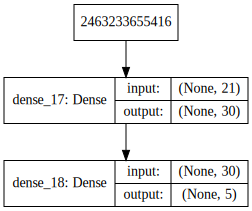

In [1299]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

import os
os.environ["PATH"] += os.pathsep + 'C:/Users/creal/graphviz-2.38/release/bin'

SVG(model_to_dot(model0, show_shapes=True).create(prog='dot', format='svg'))

In [1266]:
model0.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 15)                330       
_________________________________________________________________
dense_10 (Dense)             (None, 5)                 80        
Total params: 410
Trainable params: 410
Non-trainable params: 0
_________________________________________________________________


In [1267]:
l1 = model0.layers[0]
l2 = model0.layers[1]

In [1268]:
l1.name, type(l1), l1.output_shape, l1.activation.__name__, l1.count_params()

('dense_9', keras.layers.core.Dense, (None, 15), 'sigmoid', 330)

In [1269]:
l2.name, type(l2), l2.output_shape, l2.activation.__name__, l2.count_params()

('dense_10', keras.layers.core.Dense, (None, 5), 'softmax', 80)

In [ ]:
%%time

# fit 메서드로 트레이닝 실시 (hist로 반환하면 그래프로 뿌리기 용이하다.)
hist = model0.fit(X_train, Y_train, 
                 epochs=608, 
                 validation_data=(X_test, Y_test), 
                 verbose=2)

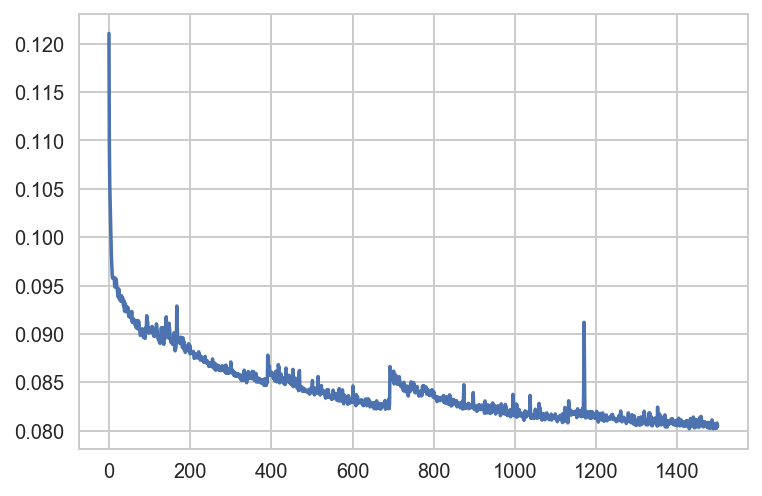

In [1205]:
plt.plot(hist.history['loss'])
plt.show()

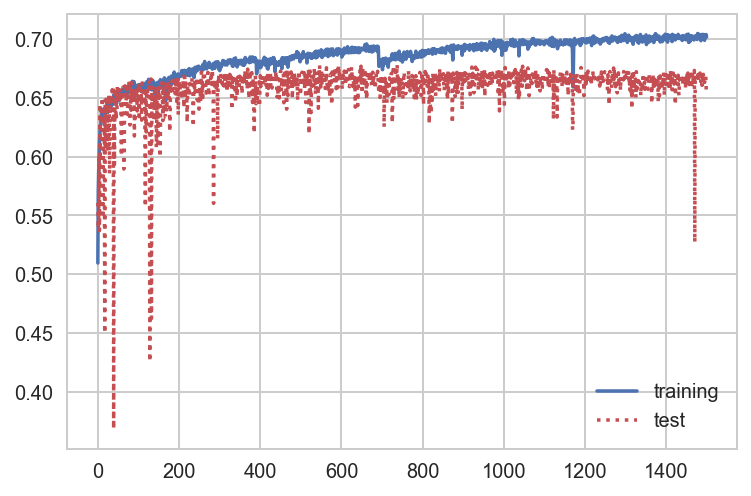

In [1206]:
#자료가 좋으면 테스트가 더 높게 나올수도 있다.
plt.plot(hist.history['acc'], 'b-', label="training")
plt.plot(hist.history['val_acc'], 'r:', label="test")
plt.legend()
plt.show()

In [1207]:
from sklearn.metrics import *
y_pred = hist.model.predict_classes(df_final,verbose=0)
# print(y_pred)
print("- Accuracy_Score : ", accuracy_score(y, y_pred))
print("- Confusion_Matrix \n",confusion_matrix(y, y_pred))
# hist.model.predict_classes

- Accuracy_Score :  0.688390886303
- Confusion_Matrix 
 [[9218    1   44  657  849]
 [  27   35   27    8  100]
 [ 236    7  548  191  573]
 [2200    0  112 1699  775]
 [1760    3  189  570 6900]]


### 신경망 Target 생성

In [ ]:
y_categ= np_utils.to_categorical(y, 5)
hist = model0.fit(df_final,y_categ,
                 epochs=1000,  
                 verbose=2)

Epoch 1/1000
 - 1s - loss: 1.4463 - acc: 0.3895
Epoch 2/1000
 - 1s - loss: 1.3385 - acc: 0.4329
Epoch 3/1000
 - 1s - loss: 1.2739 - acc: 0.4532
Epoch 4/1000
 - 1s - loss: 1.2879 - acc: 0.4538
Epoch 5/1000
 - 1s - loss: 1.2033 - acc: 0.4876
Epoch 6/1000
 - 1s - loss: 1.2102 - acc: 0.4842
Epoch 7/1000
 - 1s - loss: 1.1404 - acc: 0.5153
Epoch 8/1000
 - 1s - loss: 1.1258 - acc: 0.5300
Epoch 9/1000
 - 1s - loss: 1.1157 - acc: 0.5255
Epoch 10/1000
 - 1s - loss: 1.1058 - acc: 0.5246
Epoch 11/1000
 - 1s - loss: 1.1268 - acc: 0.5158
Epoch 12/1000
 - 1s - loss: 1.1125 - acc: 0.5233
Epoch 13/1000
 - 1s - loss: 1.1523 - acc: 0.5096
Epoch 14/1000
 - 1s - loss: 1.2285 - acc: 0.4879
Epoch 15/1000
 - 1s - loss: 1.2078 - acc: 0.4954
Epoch 16/1000
 - 1s - loss: 1.1690 - acc: 0.5215
Epoch 17/1000
 - 1s - loss: 1.1564 - acc: 0.5234
Epoch 18/1000
 - 1s - loss: 1.2764 - acc: 0.4851
Epoch 19/1000
 - 1s - loss: 1.3714 - acc: 0.4561
Epoch 20/1000
 - 1s - loss: 1.3649 - acc: 0.4649
Epoch 21/1000
 - 1s - loss: 1

 - 1s - loss: 1.2900 - acc: 0.5382
Epoch 168/1000
 - 1s - loss: 1.2537 - acc: 0.5450
Epoch 169/1000
 - 1s - loss: 1.2640 - acc: 0.5476
Epoch 170/1000
 - 1s - loss: 1.2743 - acc: 0.5483
Epoch 171/1000
 - 1s - loss: 1.3122 - acc: 0.5361
Epoch 172/1000
 - 1s - loss: 1.2844 - acc: 0.5450
Epoch 173/1000
 - 1s - loss: 1.3831 - acc: 0.5272
Epoch 174/1000
 - 1s - loss: 1.2604 - acc: 0.5489
Epoch 175/1000
 - 1s - loss: 1.2298 - acc: 0.5510
Epoch 176/1000
 - 1s - loss: 1.1747 - acc: 0.5586
Epoch 177/1000
 - 1s - loss: 1.1588 - acc: 0.5662
Epoch 178/1000
 - 1s - loss: 1.1982 - acc: 0.5522
Epoch 179/1000
 - 1s - loss: 1.1641 - acc: 0.5491
Epoch 180/1000
 - 1s - loss: 1.1541 - acc: 0.5654
Epoch 181/1000
 - 1s - loss: 1.1321 - acc: 0.5667
Epoch 182/1000
 - 1s - loss: 1.1817 - acc: 0.5586
Epoch 183/1000
 - 1s - loss: 1.1458 - acc: 0.5597
Epoch 184/1000
 - 1s - loss: 1.1324 - acc: 0.5665
Epoch 185/1000
 - 1s - loss: 1.1404 - acc: 0.5578
Epoch 186/1000
 - 1s - loss: 1.1572 - acc: 0.5568
Epoch 187/1000


 - 1s - loss: 2.6099 - acc: 0.3680
Epoch 332/1000
 - 1s - loss: 2.6984 - acc: 0.3648
Epoch 333/1000
 - 1s - loss: 2.6309 - acc: 0.3672
Epoch 334/1000
 - 1s - loss: 2.6775 - acc: 0.3650
Epoch 335/1000
 - 1s - loss: 2.6366 - acc: 0.3667
Epoch 336/1000
 - 1s - loss: 2.5818 - acc: 0.3702
Epoch 337/1000
 - 1s - loss: 2.6366 - acc: 0.3705
Epoch 338/1000
 - 1s - loss: 2.6268 - acc: 0.3702
Epoch 339/1000
 - 1s - loss: 2.6241 - acc: 0.3711
Epoch 340/1000
 - 1s - loss: 2.5608 - acc: 0.3755
Epoch 341/1000
 - 1s - loss: 2.6119 - acc: 0.3687
Epoch 342/1000
 - 1s - loss: 2.5950 - acc: 0.3686
Epoch 343/1000
 - 1s - loss: 2.6134 - acc: 0.3697
Epoch 344/1000
 - 1s - loss: 2.6470 - acc: 0.3684
Epoch 345/1000
 - 1s - loss: 2.5512 - acc: 0.3758
Epoch 346/1000
 - 1s - loss: 2.5859 - acc: 0.3715
Epoch 347/1000
 - 1s - loss: 2.5876 - acc: 0.3775
Epoch 348/1000
 - 1s - loss: 2.0492 - acc: 0.4369
Epoch 349/1000
 - 1s - loss: 2.5947 - acc: 0.3752
Epoch 350/1000
 - 1s - loss: 2.5945 - acc: 0.3690
Epoch 351/1000


 - 1s - loss: 2.4711 - acc: 0.4002
Epoch 496/1000
 - 1s - loss: 2.5107 - acc: 0.3894
Epoch 497/1000
 - 1s - loss: 2.4947 - acc: 0.4028
Epoch 498/1000
 - 1s - loss: 2.4268 - acc: 0.4058
Epoch 499/1000
 - 1s - loss: 2.4711 - acc: 0.4064
Epoch 500/1000
 - 1s - loss: 2.3687 - acc: 0.4048
Epoch 501/1000
 - 1s - loss: 2.3968 - acc: 0.3986
Epoch 502/1000
 - 1s - loss: 2.4627 - acc: 0.3922
Epoch 503/1000
 - 1s - loss: 2.4936 - acc: 0.3992
Epoch 504/1000
 - 1s - loss: 2.3834 - acc: 0.4107
Epoch 505/1000
 - 1s - loss: 2.4089 - acc: 0.4118
Epoch 506/1000
 - 1s - loss: 2.4589 - acc: 0.4035
Epoch 507/1000
 - 1s - loss: 2.4723 - acc: 0.4080
Epoch 508/1000
 - 1s - loss: 2.3489 - acc: 0.4097
Epoch 509/1000
 - 1s - loss: 2.3879 - acc: 0.4033
Epoch 510/1000
 - 1s - loss: 2.3779 - acc: 0.4157
Epoch 511/1000
 - 1s - loss: 2.3872 - acc: 0.4108
Epoch 512/1000
 - 1s - loss: 2.4928 - acc: 0.4018
Epoch 513/1000
 - 1s - loss: 2.3545 - acc: 0.4126
Epoch 514/1000
 - 1s - loss: 2.3760 - acc: 0.4167
Epoch 515/1000


 - 1s - loss: 1.9125 - acc: 0.4777
Epoch 660/1000
 - 1s - loss: 1.8688 - acc: 0.4820
Epoch 661/1000
 - 1s - loss: 1.8669 - acc: 0.4790
Epoch 662/1000
 - 1s - loss: 1.8462 - acc: 0.4806
Epoch 663/1000
 - 1s - loss: 2.0277 - acc: 0.4566
Epoch 664/1000
 - 1s - loss: 1.9094 - acc: 0.4753
Epoch 665/1000
 - 1s - loss: 1.9744 - acc: 0.4619
Epoch 666/1000
 - 1s - loss: 1.8990 - acc: 0.4804
Epoch 667/1000
 - 1s - loss: 2.0713 - acc: 0.4508
Epoch 668/1000
 - 1s - loss: 1.9887 - acc: 0.4576
Epoch 669/1000
 - 1s - loss: 1.8913 - acc: 0.4800
Epoch 670/1000
 - 1s - loss: 2.0320 - acc: 0.4503
Epoch 671/1000
 - 1s - loss: 1.8433 - acc: 0.4817
Epoch 672/1000
 - 1s - loss: 1.8709 - acc: 0.4838
Epoch 673/1000
 - 1s - loss: 1.9242 - acc: 0.4739
Epoch 674/1000
 - 1s - loss: 1.9160 - acc: 0.4752
Epoch 675/1000
 - 1s - loss: 1.8757 - acc: 0.4739
Epoch 676/1000
 - 1s - loss: 1.9305 - acc: 0.4733
Epoch 677/1000
 - 1s - loss: 1.8742 - acc: 0.4775
Epoch 678/1000
 - 1s - loss: 1.8706 - acc: 0.4723
Epoch 679/1000


 - 1s - loss: 2.0509 - acc: 0.4453
Epoch 824/1000
 - 1s - loss: 1.8741 - acc: 0.4731
Epoch 825/1000
 - 1s - loss: 1.9196 - acc: 0.4763
Epoch 826/1000
 - 1s - loss: 1.8815 - acc: 0.4812
Epoch 827/1000
 - 1s - loss: 1.9166 - acc: 0.4766
Epoch 828/1000
 - 1s - loss: 1.8862 - acc: 0.4825
Epoch 829/1000
 - 1s - loss: 1.8316 - acc: 0.4783
Epoch 830/1000
 - 1s - loss: 1.8866 - acc: 0.4742
Epoch 831/1000
 - 1s - loss: 1.9410 - acc: 0.4650
Epoch 832/1000
 - 1s - loss: 1.8398 - acc: 0.4805
Epoch 833/1000
 - 1s - loss: 1.8852 - acc: 0.4789
Epoch 834/1000
 - 1s - loss: 1.8784 - acc: 0.4804
Epoch 835/1000
 - 1s - loss: 1.9118 - acc: 0.4790
Epoch 836/1000
 - 1s - loss: 1.9316 - acc: 0.4760
Epoch 837/1000
 - 1s - loss: 1.8350 - acc: 0.4794
Epoch 838/1000
 - 1s - loss: 1.8667 - acc: 0.4785
Epoch 839/1000
 - 1s - loss: 1.8830 - acc: 0.4748
Epoch 840/1000
 - 1s - loss: 1.9216 - acc: 0.4761
Epoch 841/1000
 - 1s - loss: 1.8602 - acc: 0.4781
Epoch 842/1000
 - 1s - loss: 1.8987 - acc: 0.4745
Epoch 843/1000


In [ ]:
#자료가 좋으면 테스트가 더 높게 나올수도 있다.
plt.plot(hist.history['acc'], 'b-', label="training")
# plt.plot(hist.history['val_acc'], 'r:', label="test")
plt.legend()
plt.show()

In [ ]:
keras_pred= hist.model.predict(df_test,verbose=0)
keras_pred

In [ ]:
Final_keras = pd.DataFrame(keras_pred, columns=["Adoption","Died","Euthanasia","Return_to_owner","Transfer"])
Final_keras["ID"] = np.arange(1,len(Final_keras["Adoption"])+1)
Final_submission = Final_keras[["ID","Adoption","Died","Euthanasia","Return_to_owner","Transfer"]]
Final_submission.tail(20)

## 7. To improve performace
- AnimalType 별로 나눠서 EDA와 모델 만들어 비교할 예정
- 최적화
- 비대칭 데이터 해결

동물의 처리결과별 - 종 통계


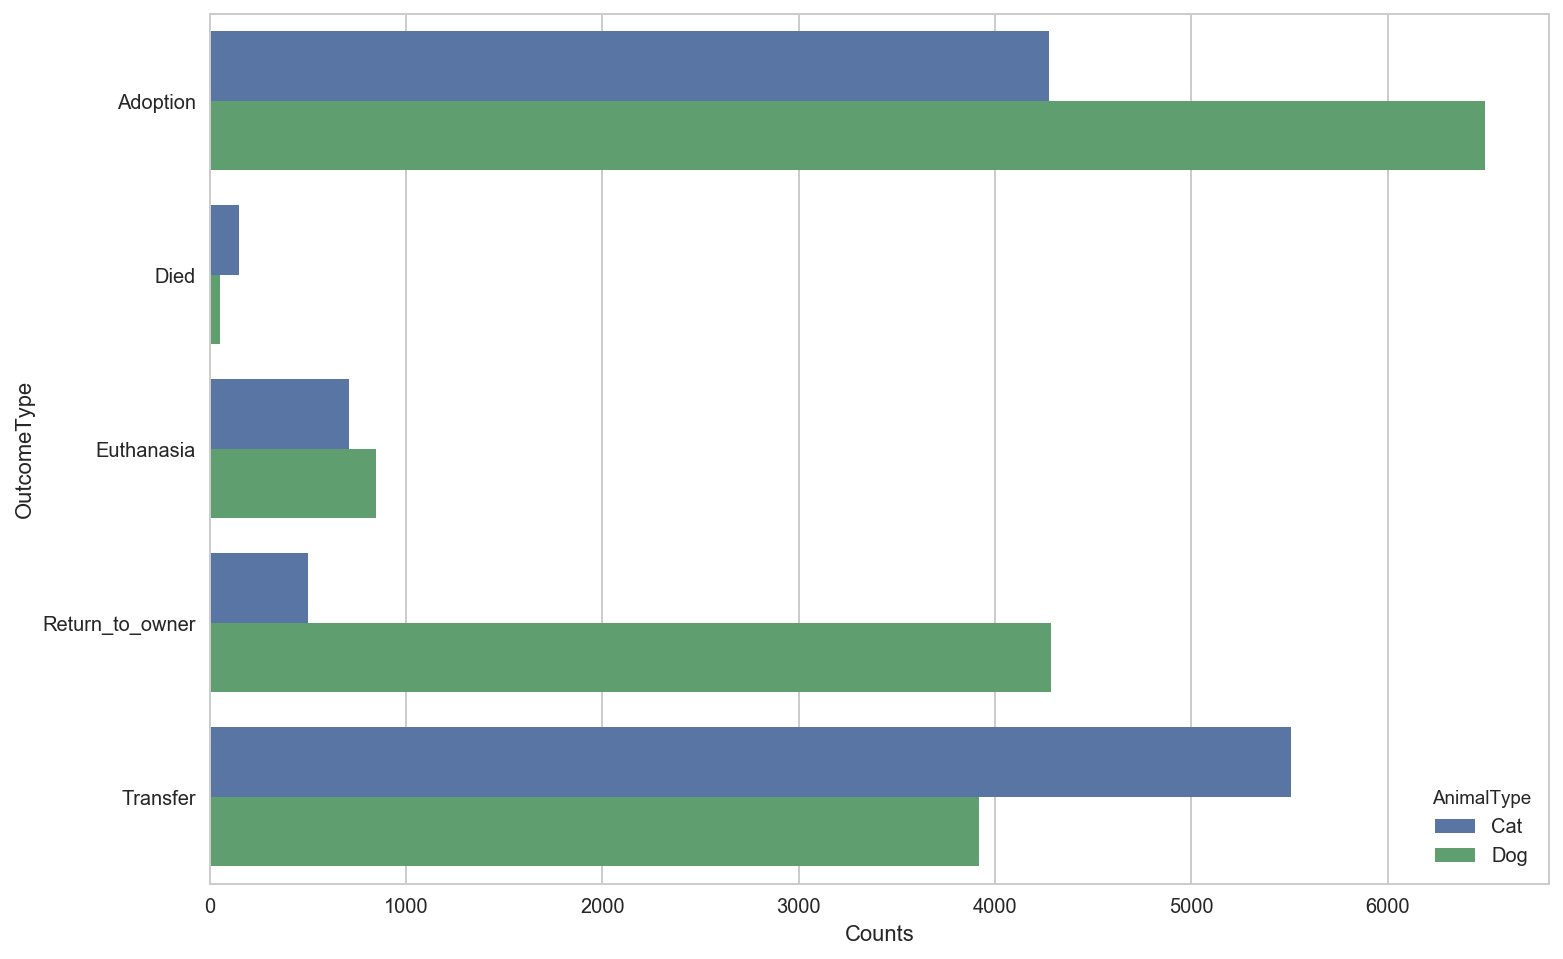

In [84]:
sorted_df = train.groupby(["OutcomeType","AnimalType"]).size().reset_index(name="count")
fig = plt.figure(figsize=(12,8))
ax = sns.barplot(data = sorted_df, x="count", y="OutcomeType", hue="AnimalType")
ax.set_xlabel('Counts')
ax.set_ylabel('OutcomeType')
print("동물의 처리결과별 - 종 통계")
# 0은 1년생 미만의 동물개체
# -1은 나이정보가 없었던 동물

# Test DATA 예측모델에 적용 --> Target 값 생성

- 사전작업 : test데이터의 신규 동물종에 대한 스펙 Breed_dev에 반영

> ### 1. 전체데이터
>
> ### 2. AnimalType 별 분할데이터로 모델 최적화
        - (강아지, 고양이 모델 따로 생성후 결합)
        - 각 모델 생성 및 예측 --> 결과값 결합

In [ ]:
# 종류 missing 데이터 찾음
#test 데이터- 강아지 종류 missing!
# tmp_test[(tmp_test["ID"]==1672)|(tmp_test["ID"]==3923)|(tmp_test["ID"]==4457)|(tmp_test["ID"]==5471)|(tmp_test["ID"]==6036)|(tmp_test["ID"]==6619)|(tmp_test["ID"]==10623)].Breed_extra.unique()
#test 데이터- 고양이 종류 missing!
# tmp_test[(tmp_test["ID"]==675)|(tmp_test["ID"]==1185)|(tmp_test["ID"]==5556)|(tmp_test["ID"]==5875)|(tmp_test["ID"]==8173)|(tmp_test["ID"]==9215)].Breed_extra.unique()

In [888]:
# 나이정보가 없는 경우는 -1로 처리한뒤 차후에 Mode값에 산입
test["SexuponOutcome"] = test["SexuponOutcome"].fillna("Unknown")
test["AgeuponOutcome"] = test["AgeuponOutcome"].fillna("-1 nodata")

test_if = test.copy()

# 전체데이터 (한번만 작동하면 됨)
# tmp_test = preprocessShelter(test_if)
# df_tcolors2, df_tbreeds2 = preprocessColorBreed(tmp_test,Breed_dev)

df_Ctgt = allCategorizer(tmp_test,cols2)

df_test = pd.concat([df_Ctgt,df_tbreeds2],axis=1) #분석제외 <== df_tcolors2,

df_test = df_test[['Name', 'sex_intact', #'sex_unknown',
                     'sex_mf', 'AnimalType', 'Age_daily_scale',
                     #'Age_code',
                     'Breed_dogM', 'Breed_Mx',
                     'Breed_Lh', 'Breed_Mh', 'Breed_Sh', #'Breed_Do', 
                     'Breed_Pitbull',
                     'Time_hour', 'Time_month', 'Time_DOW', 'Time_year', #'Time_weekend',
                     'Time_season', #'Holidays', 
                     'Breed_RestLife', 'Breed_Life', 'Breed_Agsv', 'Breed_Size',  #'Breed_Acti',
                     'Breed_Smrt', #'Breed_Frdy'
                    ]]


Categorizing start... using  ['Name', 'sex_intact', 'sex_unknown', 'sex_mf', 'AnimalType', 'Age_daily_scale', 'Age_code', 'Breed_dogM', 'Breed_Mx', 'Breed_Do', 'Breed_Lh', 'Breed_Mh', 'Breed_Sh', 'Breed_Pitbull', 'Time_hour', 'Time_month', 'Time_DOW', 'Time_year', 'Time_weekend', 'Time_season', 'Holidays']
0 , 1 , 2 , 3 , 4 , 5 , 6 , 7 , 8 , 9 , 10 , 11 , 12 , 13 , 14 , 15 , 16 , 17 , 18 , 19 , 20 , Complete!


In [1210]:
#전체데이터(무분할)
submit_proba0 = model_ls[0].predict_proba(df_test)
submit_proba0

array([[  1.62207408e-02,   5.84578861e-04,   3.59696162e-02,
          1.99461901e-01,   7.47763163e-01],
       [  8.06801799e-01,   2.43093194e-03,   9.99214197e-03,
          1.28442648e-01,   5.23324792e-02],
       [  3.86457600e-01,   8.08381669e-04,   9.60923704e-03,
          1.01412923e-01,   5.01711859e-01],
       ..., 
       [  1.68731247e-04,   1.34063949e-03,   1.98397894e-02,
          3.73750839e-04,   9.78277089e-01],
       [  5.30544106e-01,   1.65690003e-04,   9.74036254e-03,
          4.15253046e-01,   4.42967958e-02],
       [  2.38325511e-02,   3.80586011e-04,   1.10015567e-01,
          6.78420819e-01,   1.87350477e-01]])

In [1211]:
Final_data = pd.DataFrame(submit_proba0, columns=["Adoption","Died","Euthanasia","Return_to_owner","Transfer"])
Final_data["ID"] = np.arange(1,len(Final_data["Adoption"])+1)
Final_submission = Final_data[["ID","Adoption","Died","Euthanasia","Return_to_owner","Transfer"]]
Final_submission.tail(20)

,ID,Adoption,Died,Euthanasia,Return_to_owner,Transfer
11436,11437,0.859235,0.000596,0.003052,0.028821,0.108295
11437,11438,0.029605,0.001012,0.009048,0.167086,0.793249
11438,11439,0.996307,0.000178,0.000272,0.000321,0.002923
11439,11440,0.606577,0.000240,0.092091,0.189719,0.111373
11440,11441,0.000007,0.000487,0.008353,0.000299,0.990854
11441,11442,0.180331,0.002356,0.092641,0.641081,0.083591
11442,11443,0.534290,0.000134,0.004650,0.321336,0.139589
11443,11444,0.791983,0.001329,0.001538,0.027632,0.177519
11444,11445,0.002961,0.166031,0.178130,0.005496,0.647382
11445,11446,0.000021,0.001306,0.011837,0.000224,0.986613


## Kaggle 제출 결과 Score

## 동물 종에 따른 데이터 분할

In [1060]:
# 나이정보가 없는 경우는 -1로 처리한뒤 차후에 Mode값에 산입
test["SexuponOutcome"] = test["SexuponOutcome"].fillna("Unknown")
test["AgeuponOutcome"] = test["AgeuponOutcome"].fillna("-1 nodata")

#DF 설정 (고양이 or 개)
test_Cat = test[test["AnimalType"]=="Cat"].copy()
test_Dog = test[test["AnimalType"]=="Dog"].copy()


# 고양이 종 분류 데이터 (한번작동 필요)
# tmp_Cat = preprocessShelter(test_Cat)
# df_colors_cat, df_breeds_cat = preprocessColorBreed(tmp_Cat,Breed_dev)

# 강아지 종 분류 데이터 (한번작동 필요)
# tmp_Dog = preprocessShelter(test_Dog)
# df_colors_dog, df_breeds_dog = preprocessColorBreed(tmp_Dog,Breed_dev)


#카테고라이징
df_Ctg_Cat = allCategorizer(tmp_Cat,cols2)
df_Ctg_Dog = allCategorizer(tmp_Dog,cols2)

df_test_Cat = pd.concat([df_Ctg_Cat,df_breeds_cat],axis=1)# df_tcolors2,
df_test_Dog = pd.concat([df_Ctg_Dog,df_breeds_dog],axis=1)# df_tcolors2,

# 개,고양이 피쳐 On,Off------------------------------
#냥이
df_test_Cat = df_test_Cat[['Name', 'sex_intact', #'sex_unknown',
                         'sex_mf', 'AnimalType', 'Age_daily_scale',
                         #'Age_code',
                         'Breed_dogM', 'Breed_Mx',
                         'Breed_Lh', 'Breed_Mh', 'Breed_Sh', #'Breed_Do', 
                         #'Breed_Pitbull',
                         'Time_hour', 'Time_month', 'Time_DOW', 'Time_year', #'Time_weekend',
                         'Time_season', #'Holidays', 
                         'Breed_RestLife', 'Breed_Life', 'Breed_Size', #'Breed_Agsv', #'Breed_Acti',
                         'Breed_Smrt', #'Breed_Frdy'
                        ]]
#개
df_test_Dog = df_test_Dog[['Name', 'sex_intact', #'sex_unknown',
                         'sex_mf', 'AnimalType', 'Age_daily_scale',
                         #'Age_code',
                         'Breed_dogM', 'Breed_Mx',
                         'Breed_Lh', 'Breed_Mh', 'Breed_Sh', #'Breed_Do', 
                         'Breed_Pitbull',
                         'Time_hour', 'Time_month', 'Time_DOW', 'Time_year', #'Time_weekend',
                         'Time_season', #'Holidays', 
                         'Breed_RestLife', 'Breed_Life', 'Breed_Agsv', 'Breed_Size',  #'Breed_Acti',
                         'Breed_Smrt', #'Breed_Frdy'
                        ]]


Categorizing start... using  ['Name', 'sex_intact', 'sex_unknown', 'sex_mf', 'AnimalType', 'Age_daily_scale', 'Age_code', 'Breed_dogM', 'Breed_Mx', 'Breed_Do', 'Breed_Lh', 'Breed_Mh', 'Breed_Sh', 'Breed_Pitbull', 'Time_hour', 'Time_month', 'Time_DOW', 'Time_year', 'Time_weekend', 'Time_season', 'Holidays']
0 , 1 , 2 , 3 , 4 , 5 , 6 , 7 , 8 , 9 , 10 , 11 , 12 , 13 , 14 , 15 , 16 , 17 , 18 , 19 , 20 , Complete!
Categorizing start... using  ['Name', 'sex_intact', 'sex_unknown', 'sex_mf', 'AnimalType', 'Age_daily_scale', 'Age_code', 'Breed_dogM', 'Breed_Mx', 'Breed_Do', 'Breed_Lh', 'Breed_Mh', 'Breed_Sh', 'Breed_Pitbull', 'Time_hour', 'Time_month', 'Time_DOW', 'Time_year', 'Time_weekend', 'Time_season', 'Holidays']
0 , 1 , 2 , 3 , 4 , 5 , 6 , 7 , 8 , 9 , 10 , 11 , 12 , 13 , 14 , 15 , 16 , 17 , 18 , 19 , 20 , Complete!


### 강아지 LightGBM최적화

model creating. max_depth==>, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20
model testing...
LGB Model1: CV Mean score: 0.609 --- acuraccy score : 0.616
LGB Model2: CV Mean score: 0.611 --- acuraccy score : 0.627
LGB Model3: CV Mean score: 0.613 --- acuraccy score : 0.640
LGB Model4: CV Mean score: 0.615 --- acuraccy score : 0.654
LGB Model5: CV Mean score: 0.614 --- acuraccy score : 0.664
LGB Model6: CV Mean score: 0.613 --- acuraccy score : 0.668
LGB Model7: CV Mean score: 0.613 --- acuraccy score : 0.671
LGB Model8: CV Mean score: 0.615 --- acuraccy score : 0.670
LGB Model9: CV Mean score: 0.614 --- acuraccy score : 0.672
LGB Model10: CV Mean score: 0.616 --- acuraccy score : 0.672
LGB Model11: CV Mean score: 0.615 --- acuraccy score : 0.674
LGB Model12: CV Mean score: 0.615 --- acuraccy score : 0.673
LGB Model13: CV Mean score: 0.617 --- acuraccy score : 0.673
LGB Model14: CV Mean score: 0.616 --- acuraccy score : 0.674
LGB Model15: CV Mean score: 0.615 --- acurac

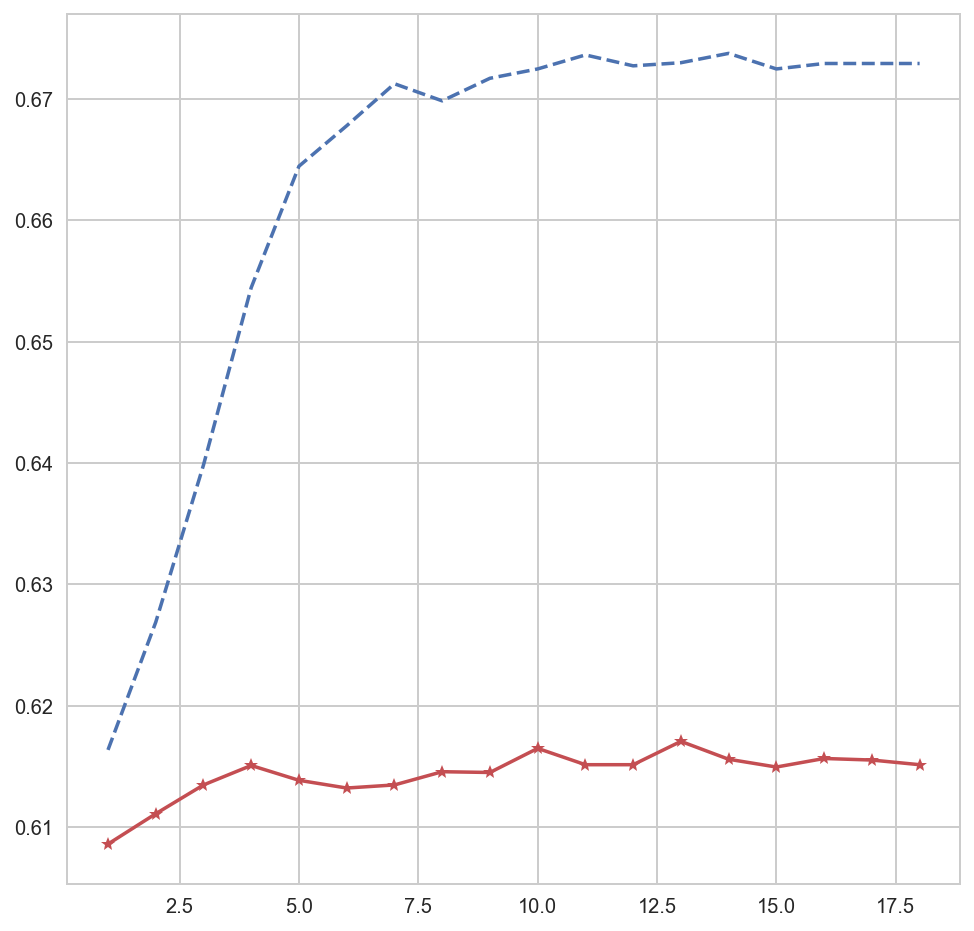

In [1187]:
#강아지용
import lightgbm as lgb

#강아지용 training set
df_dfinal = df_final[df_final["AnimalType"]==1].copy()

from sklearn.preprocessing import LabelEncoder
dog_tr = train[train["AnimalType"]=="Dog"].copy()
dle = LabelEncoder()
dy = dog_tr["OutcomeType"]
dle.fit(dy)
dy= le.transform(dy)

dog_ls = []
score_ls = []
accur_ls = []

# LigntGBM 모델 자동생성 반복문
print("model creating. max_depth==>",end="")
for i in range(3,21,1):
    LGB = lgb.LGBMClassifier(boosting_type="gbdt", n_estimators=100, objective="multi:softprob",
                             max_depth=i, random_state=0).fit(df_dfinal,dy)    
    print(",",i,end="")
    dog_ls.append(LGB)

# 모델 CV돌리기
print("\nmodel testing...")
for i, model in enumerate(dog_ls):
    scores = cross_val_score(model, df_dfinal, dy,cv=10)
    accuracy = accuracy_score(dy,model.predict(df_dfinal))
    print(("LGB Model{0:d}: CV Mean score: {1:.3f}").format(i+1,np.mean(scores)), end="")
    print((" --- acuraccy score : {0:.3f}").format(accuracy)) # Kfold 안했을때 비교
    score_ls.append(np.mean(scores))
    accur_ls.append(accuracy)
    
# 결과 플롯팅 
plt.figure(figsize=(8,8))
plt.plot(range(1,len(score_ls)+1),list(score_ls),'-*r')
plt.plot(range(1,len(accur_ls)+1),list(accur_ls),'--b')
plt.show()

#고양이 cv최고기록 : 0.821 - n-esti:250/ depth:12/ obj:'multi:softprob'/
#강아지 cv최고기록 : 0.618 - n-esti:200/ depth:-1/ obj:'multi:softprob'(종간략화)// 0.619 nesti:250/depth:3(종세분화)

# 진행된 최근 점수 : 0.615 - 0.676 = ___ nesti = 200/depth = 5,(19)
# 결합모형 캐글최고점수 : 0.617 - 0.676 = ___ nesti = 150/depth = (6),18

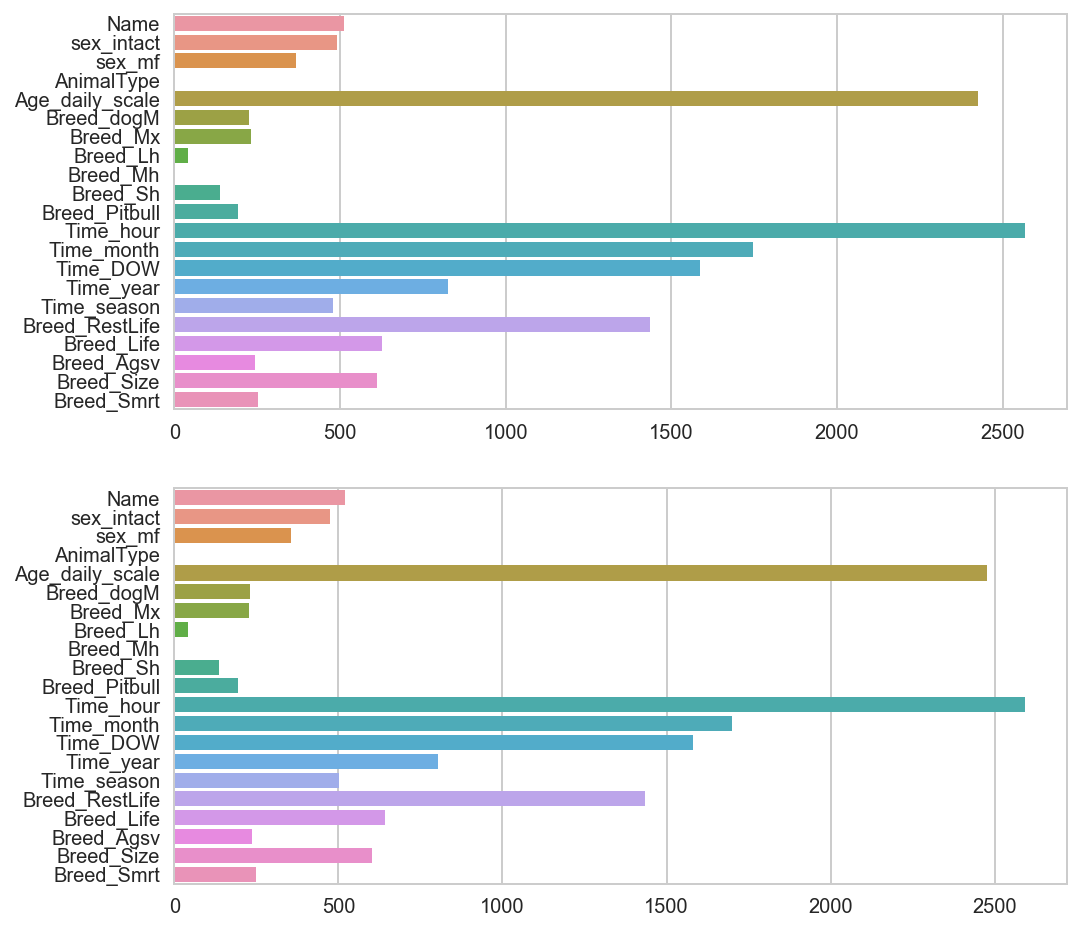

In [1188]:
## 피쳐 중요도
plt.figure(figsize=(8,8))
plt.subplot(211)
importance = dog_ls[9].feature_importances_
sns.barplot(y=df_dfinal.columns[:31], x=importance[:31])
plt.subplot(212)
importance = dog_ls[12].feature_importances_
# plt.figure(figsize=(8,6))
sns.barplot(y=df_dfinal.columns[:31], x=importance[:31])


### 고양이 LightGBM최적화

model creating. max_depth==>, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20
model testing...
LGB Model1: CV Mean score: 0.790 --- acuraccy score : 0.793
LGB Model2: CV Mean score: 0.795 --- acuraccy score : 0.803
LGB Model3: CV Mean score: 0.800 --- acuraccy score : 0.811
LGB Model4: CV Mean score: 0.803 --- acuraccy score : 0.823
LGB Model5: CV Mean score: 0.806 --- acuraccy score : 0.828
LGB Model6: CV Mean score: 0.808 --- acuraccy score : 0.831
LGB Model7: CV Mean score: 0.807 --- acuraccy score : 0.832
LGB Model8: CV Mean score: 0.807 --- acuraccy score : 0.831
LGB Model9: CV Mean score: 0.807 --- acuraccy score : 0.833
LGB Model10: CV Mean score: 0.808 --- acuraccy score : 0.832
LGB Model11: CV Mean score: 0.807 --- acuraccy score : 0.831
LGB Model12: CV Mean score: 0.808 --- acuraccy score : 0.832
LGB Model13: CV Mean score: 0.807 --- acuraccy score : 0.832
LGB Model14: CV Mean score: 0.807 --- acuraccy score : 0.832
LGB Model15: CV Mean score: 0.807 --- acurac

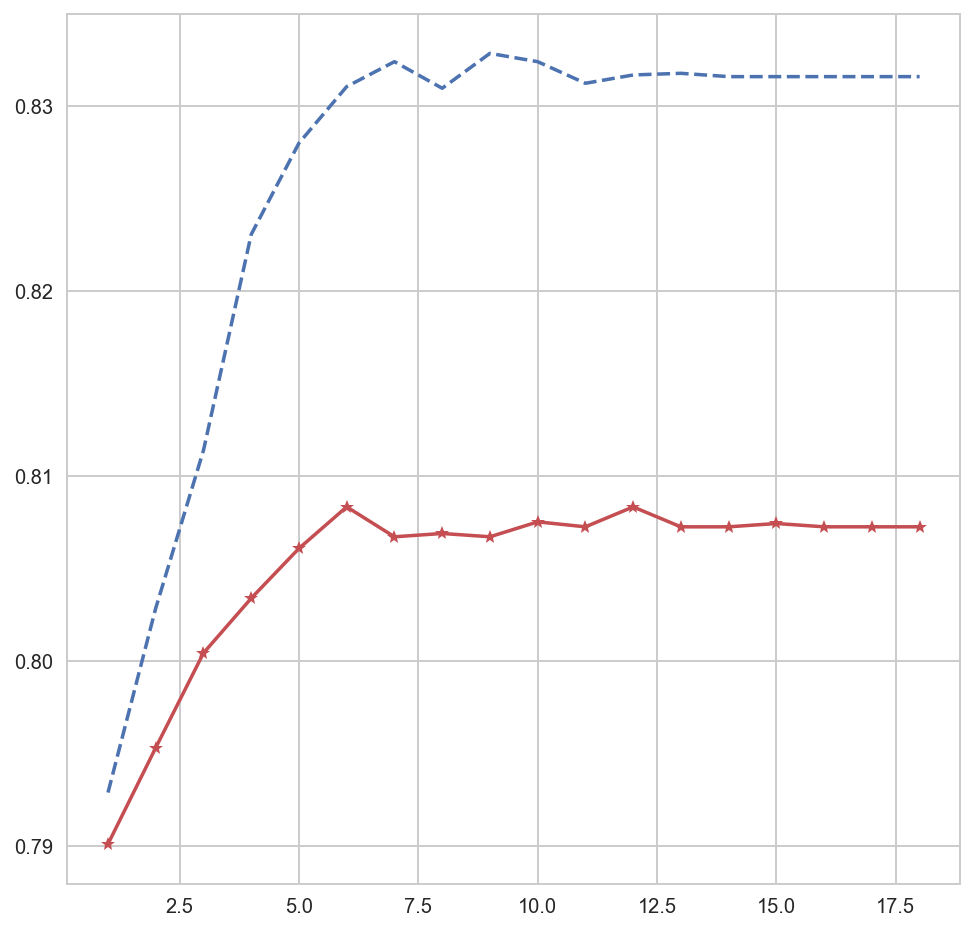

In [1109]:
#고양이용
import lightgbm as lgb

#고양이용 training set
df_cfinal = df_final[df_final["AnimalType"]==0].copy()
df_cfinal = df_cfinal[['Name', 'sex_intact', #'sex_unknown',
                         'sex_mf', 'AnimalType', 'Age_daily_scale',
                         #'Age_code',
                         'Breed_dogM', 'Breed_Mx',
                         'Breed_Lh', 'Breed_Mh', 'Breed_Sh', #'Breed_Do', 
                         #'Breed_Pitbull',
                         'Time_hour', 'Time_month', 'Time_DOW', 'Time_year', #'Time_weekend',
                         'Time_season', #'Holidays', 
                         'Breed_RestLife', 'Breed_Life', 'Breed_Size', #'Breed_Agsv', #'Breed_Acti',
                         'Breed_Smrt', #'Breed_Frdy'
                        ]]

from sklearn.preprocessing import LabelEncoder
cat_tr = train[train["AnimalType"]=="Cat"].copy()
cle = LabelEncoder()
cy = cat_tr["OutcomeType"]
cle.fit(cy)
cy= le.transform(cy)

cat_ls = []
score_ls = []
accur_ls = []

# LigntGBM 모델 자동생성 반복문
print("model creating. max_depth==>",end="")
for i in range(3,21,1):
    LGB = lgb.LGBMClassifier(boosting_type="gbdt", n_estimators=50, objective="multi:softprob",
                             max_depth=i, random_state=0).fit(df_cfinal,cy)    
    print(",",i,end="")
    cat_ls.append(LGB)

# 모델 CV돌리기
print("\nmodel testing...")
for i, model in enumerate(cat_ls):
    scores = cross_val_score(model, df_cfinal, cy,cv=10)
    accuracy = accuracy_score(cy,model.predict(df_cfinal))
    print(("LGB Model{0:d}: CV Mean score: {1:.3f}").format(i+1,np.mean(scores)), end="")
    print((" --- acuraccy score : {0:.3f}").format(accuracy)) # Kfold 안했을때 비교
    score_ls.append(np.mean(scores))
    accur_ls.append(accuracy)
    
# 결과 플롯팅 
plt.figure(figsize=(8,8))
plt.plot(range(1,len(score_ls)+1),list(score_ls),'-*r')
plt.plot(range(1,len(accur_ls)+1),list(accur_ls),'--b')
plt.show()

#고양이 cv최고기록 : 0.821 - n-esti:250/ depth:12/ obj:'multi:softprob'/
#강아지 cv최고기록 : 0.618 - n-esti:200/ depth:-1/ obj:'multi:softprob'(종간략화)// 0.619 nesti:250/depth:3(종세분화)

# 진행된 최근 점수 : 0.817 - 0.913 = 72 ___ nesti = 250/depth = 11,(14),18
# 결합모형 캐글최고점수 : 0.817 - 0.899 = 72 ___ nesti = 200/depth = 11, (14), 18

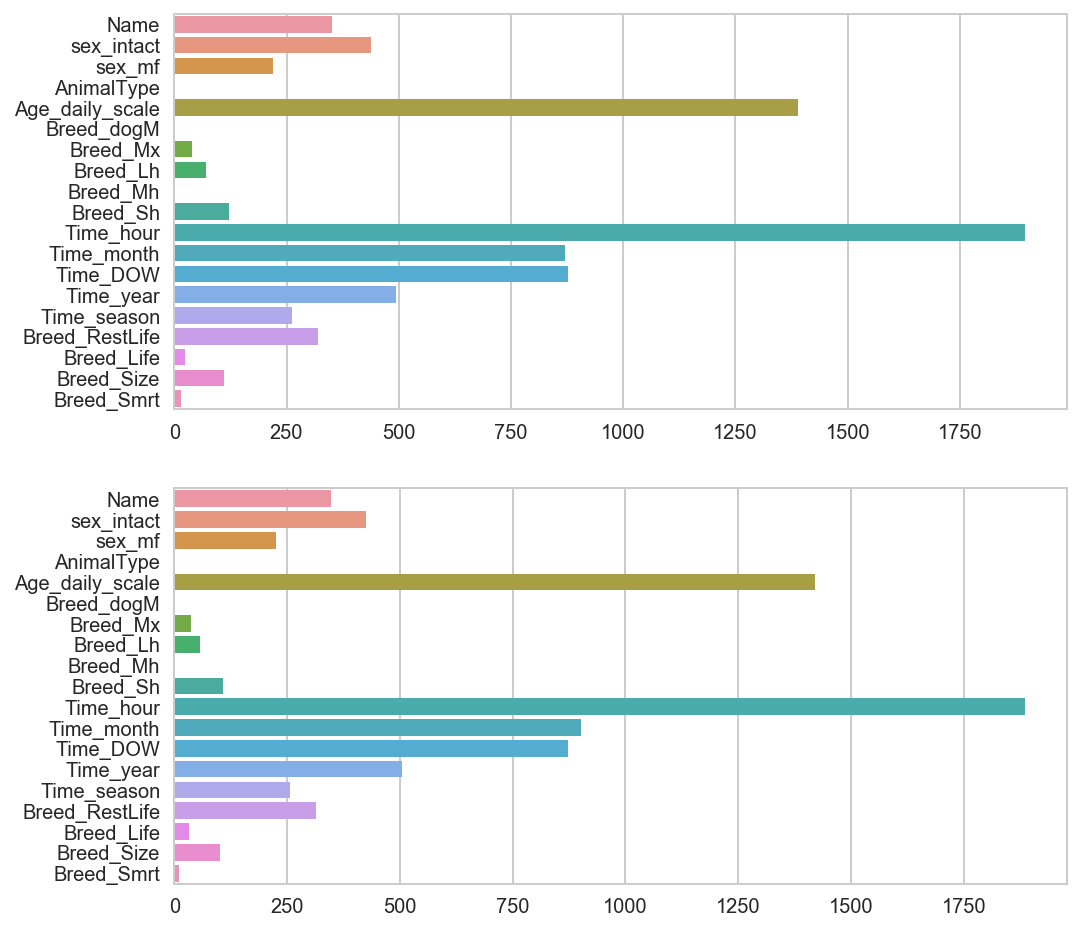

In [1112]:
## 피쳐 중요도

plt.figure(figsize=(8,8))
plt.subplot(211)
importance = cat_ls[5].feature_importances_
sns.barplot(y=df_cfinal.columns[:31], x=importance[:31])
plt.subplot(212)
importance = cat_ls[11].feature_importances_
sns.barplot(y=df_cfinal.columns[:31], x=importance[:31])

### 종별 Target값 산출

In [1113]:
### 고양이
submit_proba_c = cat_ls[11].predict_proba(df_test_Cat)
submit_proba_c

array([[ 0.39564077,  0.01587425,  0.02306889,  0.20629405,  0.35912204],
       [ 0.31463484,  0.08865336,  0.44953039,  0.09709797,  0.05008343],
       [ 0.87372144,  0.00849444,  0.00847541,  0.02034129,  0.08896743],
       ..., 
       [ 0.68800055,  0.01103941,  0.01417713,  0.01159466,  0.27518825],
       [ 0.00480552,  0.04961831,  0.01923665,  0.00580192,  0.92053761],
       [ 0.01562455,  0.01468224,  0.33459051,  0.01255566,  0.62254704]])

In [1114]:
result_cat = pd.DataFrame(submit_proba_c, columns=["Adoption","Died","Euthanasia","Return_to_owner","Transfer"])
result_cat.tail()

,Adoption,Died,Euthanasia,Return_to_owner,Transfer
4795,0.004506,0.014471,0.025431,0.005440,0.950152
4796,0.974785,0.003839,0.004914,0.007576,0.008886
4797,0.688001,0.011039,0.014177,0.011595,0.275188
4798,0.004806,0.049618,0.019237,0.005802,0.920538
4799,0.015625,0.014682,0.334591,0.012556,0.622547


In [1193]:
###### 강아지
submit_proba_d = dog_ls[9].predict_proba(df_test_Dog)
submit_proba_d

array([[ 0.01834659,  0.00166979,  0.06805071,  0.28357369,  0.62835923],
       [ 0.77101531,  0.00097501,  0.01795264,  0.133893  ,  0.07616404],
       [ 0.09935547,  0.00673263,  0.03363945,  0.17658567,  0.68368678],
       ..., 
       [ 0.57806574,  0.00112019,  0.00703197,  0.31723167,  0.09655043],
       [ 0.44470625,  0.00129349,  0.01496029,  0.44107062,  0.09796935],
       [ 0.05763386,  0.00224617,  0.17884032,  0.58440108,  0.17687857]])

In [1194]:
result_dog = pd.DataFrame(submit_proba_d, columns=["Adoption","Died","Euthanasia","Return_to_owner","Transfer"])
result_dog.tail()

,Adoption,Died,Euthanasia,Return_to_owner,Transfer
6651,0.901461,0.000442,0.001261,0.006363,0.090473
6652,0.417113,0.000893,0.004567,0.070924,0.506503
6653,0.578066,0.001120,0.007032,0.317232,0.096550
6654,0.444706,0.001293,0.014960,0.441071,0.097969
6655,0.057634,0.002246,0.178840,0.584401,0.176879


In [1159]:
#merging - 고양이,강아지 합치기

cat_i,dog_i = 0,0
sub_ls = []
for idx in range(0,len(test["ID"])):
#     print(idx,end="")
    if test.AnimalType[idx]=="Cat":
        sub_ls.append(dict(result_cat.iloc[cat_i]))
        cat_i += 1
    else :
        sub_ls.append(dict(result_dog.iloc[dog_i]))
        dog_i += 1
Final_submission = pd.DataFrame(sub_ls)
Final_submission["ID"] = np.arange(1,len(Final_submission["Adoption"])+1)
Final_submission = Final_submission[["ID","Adoption","Died","Euthanasia","Return_to_owner","Transfer"]]
Final_submission.head(10)

,ID,Adoption,Died,Euthanasia,Return_to_owner,Transfer
0,1,0.009711,0.000264,0.039173,0.289331,0.661521
1,2,0.778121,0.000611,0.012248,0.137891,0.071129
2,3,0.395641,0.015874,0.023069,0.206294,0.359122
3,4,0.068490,0.000749,0.022562,0.192271,0.715928
4,5,0.406178,0.000293,0.005567,0.510810,0.077152
5,6,0.201915,0.000355,0.031685,0.556259,0.209786
6,7,0.314635,0.088653,0.449530,0.097098,0.050083
7,8,0.873721,0.008494,0.008475,0.020341,0.088967
8,9,0.820198,0.000080,0.001251,0.145536,0.032935
9,10,0.385914,0.001071,0.068960,0.469243,0.074811


In [1195]:
# cross change merging - 특정종은 전체데이터모델에서, 다른종은 최적화모델에서
# 고양이(특화모델),강아지(전체모델) 합치기

cat_i,dog_i = 0,0
temp_cat = Final_data[test["AnimalType"]=="Cat"].copy()
sub_ls = []
for idx in range(0,len(test["ID"])):
#     print(idx,end="")
    if test.AnimalType[idx]=="Cat":
        sub_ls.append(dict(temp_cat.iloc[cat_i]))
        cat_i += 1
    else :
        sub_ls.append(dict(result_dog.iloc[dog_i]))
        dog_i += 1
Final_submission = pd.DataFrame(sub_ls)
Final_submission["ID"] = np.arange(1,len(Final_submission["Adoption"])+1)
Final_submission = Final_submission[["ID","Adoption","Died","Euthanasia","Return_to_owner","Transfer"]]
Final_submission.head(10)

,ID,Adoption,Died,Euthanasia,Return_to_owner,Transfer
0,1,0.018347,0.001670,0.068051,0.283574,0.628359
1,2,0.771015,0.000975,0.017953,0.133893,0.076164
2,3,0.386458,0.000808,0.009609,0.101413,0.501712
3,4,0.099355,0.006733,0.033639,0.176586,0.683687
4,5,0.406741,0.001290,0.006355,0.505970,0.079644
5,6,0.216766,0.001393,0.036284,0.534382,0.211176
6,7,0.216291,0.003072,0.555786,0.139421,0.085430
7,8,0.888680,0.002791,0.004093,0.011061,0.093374
8,9,0.871105,0.000896,0.002543,0.090975,0.034481
9,10,0.458960,0.001859,0.064099,0.405851,0.069231


## 분석된 Final Proba - target값 경향분석

In [985]:
# Final_submission[Final_submission["Adoption"]>0.948].count()
# sum([int(i) for i in y[Final_submission["Adoption"]>0.948] == 0])
# Final_submission[Final_submission["Died"]>0.34].count()
# sum([int(i) for i in y[Final_submission["Died"]>0.34] == 1])
# Final_submission[Final_submission["Euthanasia"]>0.69].count()
# sum([int(i) for i in y[Final_submission["Euthanasia"]>0.69] == 2])
# Final_submission[Final_submission["Return_to_owner"]>0.4].count()
# sum([int(i) for i in y[Final_submission["Return_to_owner"]>0.4] == 3])
# Final_submission[Final_submission["Transfer"]>0.937].count()
# sum([int(i) for i in y[Final_submission["Transfer"]>0.937] == 4])

In [754]:
# 유의수준 1%미만으로 보고 Proba극한으로 변형 (이건 하지 않기로...)
def changeProba(df_raw,col,val):
    df = df_raw.copy()
    idxs = df[col] > val
    df.Adoption[idxs] = int(col=='Adoption')
    df.Died[idxs] = int(col=='Died')
    df.Euthanasia[idxs] = int(col=='Euthanasia')
    df.Return_to_owner[idxs] = int(col=='Return_to_owner')
    df.Transfer[idxs] = int(col=='Transfer')
    return df

# adoption 0.8 == 171/3671 오차율
# adoption 0.85== 79/2732 오차율
# adoption 0.9 == 44/1847 오차율
# adoption 0.92== 18/1164 오차율 
# adoption 0.93== 10/956 오차율 1.04%
# adoption 0.94== 8/840 오차율 0.95%
# adoption 0.945== 5/526 오차율 0.95%
# adoption 0.948== 2/246 오차율 0.81%
# adoption 0.95== 0/4 오차율 0%
# Final_submission = changeProba(Final_submission,"Adoption",0.93)

# Died 0.3 == 3/43 오차율
# Died 0.33== 2/40 오차율
# Died 0.34== 0/38 오차율 0%
# Final_submission = changeProba(Final_submission,"Died",0.34)

# Euthan 0.5 == 71/339 오차율
# Euthan 0.6 == 30/199 오차율
# Euthan 0.65== 13/125 오차율
# Euthan 0.7 == 1/54 오차율 1.85%
# Euthan 0.71== 1/42 오차율
# Euthan 0.72== 1/33 오차율
# Euthan 0.73 == 0/23 오차율 0%
# Final_submission = changeProba(Final_submission,"Euthanasia",0.75)

# Return 0.65 == 11/109 오차율
# Return 0.67 == 3/70 오차율
# Return 0.7 == 1/31 오차율 3.2%
# Return 0.72== 1/13 오차율
# Return 0.73== 0/6 오차율 0%
Final_submission = changeProba(Final_submission,"Return_to_owner",0.73)

# Transfer 0.75 == 206/4196 오차율 5%
# Transfer 0.8 == 142/3561 오차율 
# Transfer 0.85 == 100/2985 오차율 3.3%
# Transfer 0.9 == 66/2474 오차율 2.66%
# Transfer 0.92 == 41/1901 오차율 2.16%
# Transfer 0.93 == 25/1301 오차율 1.92%
# Transfer 0.935== 16/1065 오차율 1.5%
# Transfer 0.937== 10/851 오차율 1.17%
# Transfer 0.938== 7/666 오차율 1.05%
# Transfer 0.94 == 4/322 오차율 1.24%
# Transfer 0.942== 3/142 오차율
Final_submission = changeProba(Final_submission,"Transfer",0.90)

C:\Users\creal\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\creal\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
C:\Users\creal\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\creal\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a

In [757]:
Final_submission[Final_submission["Return_to_owner"]==1]

,ID,Adoption,Died,Euthanasia,Return_to_owner,Transfer
561,562,0.0,0.0,0.0,1.0,0.0
1402,1403,0.0,0.0,0.0,1.0,0.0
1485,1486,0.0,0.0,0.0,1.0,0.0
2636,2637,0.0,0.0,0.0,1.0,0.0
3259,3260,0.0,0.0,0.0,1.0,0.0
4241,4242,0.0,0.0,0.0,1.0,0.0
5894,5895,0.0,0.0,0.0,1.0,0.0
6467,6468,0.0,0.0,0.0,1.0,0.0
6679,6680,0.0,0.0,0.0,1.0,0.0
10434,10435,0.0,0.0,0.0,1.0,0.0


# Submission CSV파일 생성

In [1291]:
Final_submission.to_csv('NeuralNetwork6_KERAS(tanh30_softmax5_lr1_2_crossentropy_epoch600).csv', index=False) # Merged_cross_05_Cat(ALLd16,ne250)AndDog(d12,ne100)

### 최종 Kaggle 순위

In [984]:
# 캐글순위 최종 상위 16.7%
267/1599


0.1669793621013133